# Exploration and Comparison of Transformers for Image Classification

## Few-Shot Linear Probing using CLIP

Linear probing is an experiment that involves training a linear classifier on top of pre-trained frozen features of the model.

Few-shot learning involves showing the model only a small number of images per class. For example, showing only one image per class makes it a one-shot learning.

For this experiment, **(1, 2, 4, 8, 16)** shots will be used.

### CLIP (Contrastive Language-Image Pre-Training)

The CLIP model was proposed in *Learning Transferable Visual Models From Natural Language Supervision by Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever*. 

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

https://arxiv.org/abs/2103.0002030

Linear probing with CLIP is done by using its vision encoder with an image classification head on top (a linear layer on top of the pooled final hidden states of the patch tokens) e.g. for ImageNet.

https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPForImageClassification

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load CLIP image processor used for image pre-processing. Tokenizer is not needed as the text encoder part of the model is not used.

In [5]:
processor, _ = get_clip_processor_and_tokenizer()

Print the pre-processing operations done by the processor.

In [6]:
processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [10]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [12]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [14]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [16]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [18]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for the experiments and print its settings.

In [3]:
config = Config(
    num_epochs=10, 
    lr=1e-3, 
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.001,
 'num_epochs': 10,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty array to store dataset accuracies for each experiment.

In [20]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Few-Shot Linear Probing (n=1)


Model is shown only 1 image per class from the dataset.

#### RESISC45

In [25]:
clip_resisc45_1 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
get_model_params(clip_resisc45_1)

Parameters: 85.83M


In [27]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45_1,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


Epochs: 1/10 | train_loss: 4.1955 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00, 10.92it/s]


Epochs: 2/10 | train_loss: 3.7201 | train_acc: 0.0889


100%|██████████| 6/6 [00:00<00:00, 10.72it/s]


Epochs: 3/10 | train_loss: 3.3964 | train_acc: 0.3556


100%|██████████| 6/6 [00:00<00:00, 10.98it/s]


Epochs: 4/10 | train_loss: 3.1368 | train_acc: 0.6222


100%|██████████| 6/6 [00:00<00:00, 10.50it/s]


Epochs: 5/10 | train_loss: 2.8902 | train_acc: 0.9333


100%|██████████| 6/6 [00:00<00:00, 10.78it/s]


Epochs: 6/10 | train_loss: 2.6497 | train_acc: 0.9778


100%|██████████| 6/6 [00:00<00:00, 10.84it/s]


Epochs: 7/10 | train_loss: 2.4218 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


Epochs: 8/10 | train_loss: 2.2031 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


Epochs: 9/10 | train_loss: 2.0131 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 11.02it/s]

Epochs: 10/10 | train_loss: 1.8000 | train_acc: 1.0000


In [28]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45_1,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:15<00:00, 10.43it/s]

test_loss: 2.8816 | test_acc: 0.4760


In [29]:
resisc45_accs.append(resisc45_acc)

In [30]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9867549668874173),
 ('snowberg', 0.9182389937106918),
 ('airport', 0.8641975308641975),
 ('beach', 0.8),
 ('harbor', 0.795774647887324)]

In [31]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('church', 0.03496503496503497),
 ('industrial area', 0.03571428571428571),
 ('tennis court', 0.041666666666666664),
 ('commercial area', 0.05),
 ('medium residential', 0.061224489795918366)]

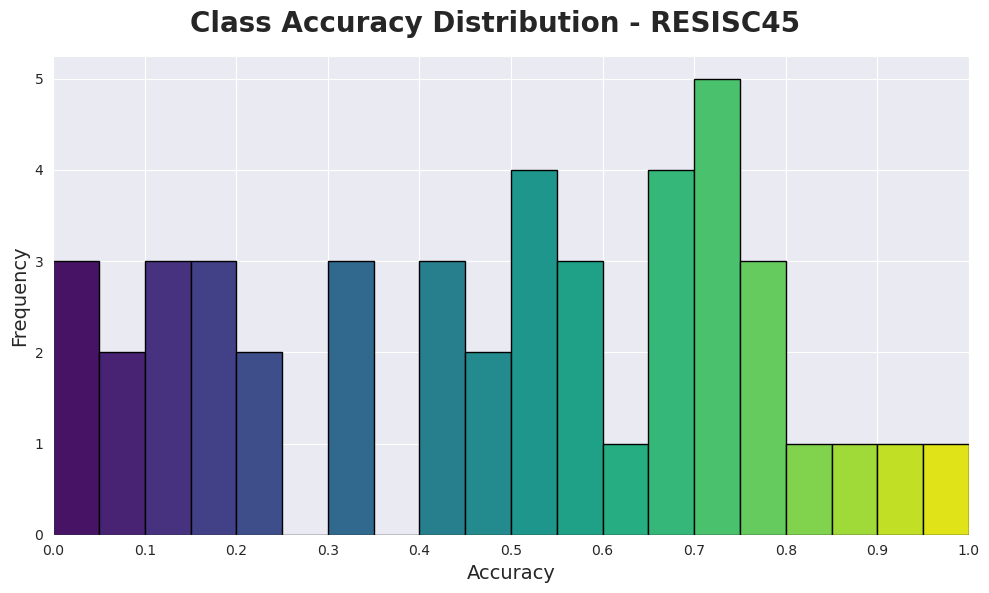

In [32]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [33]:
clip_food101_1 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
get_model_params(clip_food101_1)

Parameters: 85.88M


In [35]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101_1,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


Epochs: 1/10 | train_loss: 5.2559 | train_acc: 0.0099


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Epochs: 2/10 | train_loss: 4.5003 | train_acc: 0.0594


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


Epochs: 3/10 | train_loss: 4.0745 | train_acc: 0.4554


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


Epochs: 4/10 | train_loss: 3.7371 | train_acc: 0.9010


100%|██████████| 13/13 [00:01<00:00,  9.12it/s]


Epochs: 5/10 | train_loss: 3.3999 | train_acc: 0.9703


100%|██████████| 13/13 [00:01<00:00,  9.10it/s]


Epochs: 6/10 | train_loss: 3.0843 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


Epochs: 7/10 | train_loss: 2.7984 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


Epochs: 8/10 | train_loss: 2.5054 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Epochs: 9/10 | train_loss: 2.2428 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]

Epochs: 10/10 | train_loss: 1.9853 | train_acc: 1.0000


In [36]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101_1,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:59<00:00,  8.79it/s]


test_loss: 3.5677 | test_acc: 0.3587


In [37]:
food101_accs.append(food101_acc)

In [38]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.964),
 ('pizza', 0.912),
 ('macarons', 0.884),
 ('mussels', 0.808),
 ('fried rice', 0.804)]

In [39]:
get_bottom_5_accuracies(food101_per_class_acc)

[('dumplings', 0.0),
 ('waffles', 0.0),
 ('scallops', 0.008),
 ('panna cotta', 0.012),
 ('fish and chips', 0.02)]

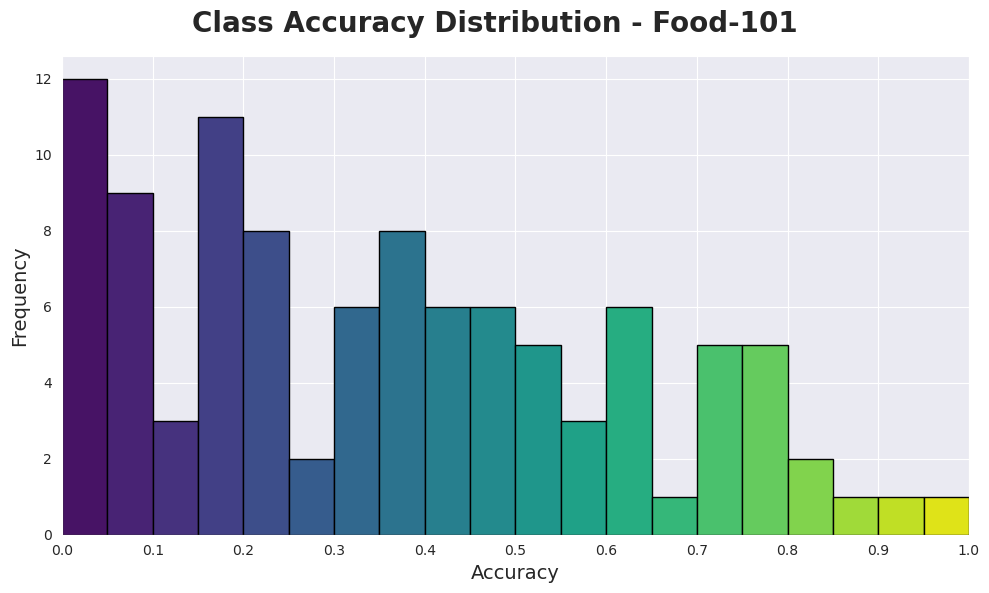

In [40]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [41]:
clip_fer2013_1 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
get_model_params(clip_fer2013_1)

Parameters: 85.80M


In [43]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013_1,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


Epochs: 1/10 | train_loss: 1.9136 | train_acc: 0.1429


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Epochs: 2/10 | train_loss: 1.8053 | train_acc: 0.4286


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Epochs: 3/10 | train_loss: 1.7047 | train_acc: 0.5714


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Epochs: 4/10 | train_loss: 1.6100 | train_acc: 0.7143


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


Epochs: 5/10 | train_loss: 1.5195 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Epochs: 6/10 | train_loss: 1.4324 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Epochs: 7/10 | train_loss: 1.3482 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Epochs: 8/10 | train_loss: 1.2665 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Epochs: 9/10 | train_loss: 1.1875 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]

Epochs: 10/10 | train_loss: 1.1112 | train_acc: 1.0000


In [44]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013_1,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:40<00:00, 11.12it/s]

test_loss: 1.8972 | test_acc: 0.2262


In [45]:
fer2013_accs.append(fer2013_acc)

In [46]:
fer2013_per_class_acc

{'angry': 0.31160896130346233,
 'disgust': 0.2545454545454545,
 'fear': 0.22348484848484848,
 'happy': 0.23321956769055746,
 'sad': 0.22895622895622897,
 'surprise': 0.15384615384615385,
 'neutral': 0.19488817891373802}

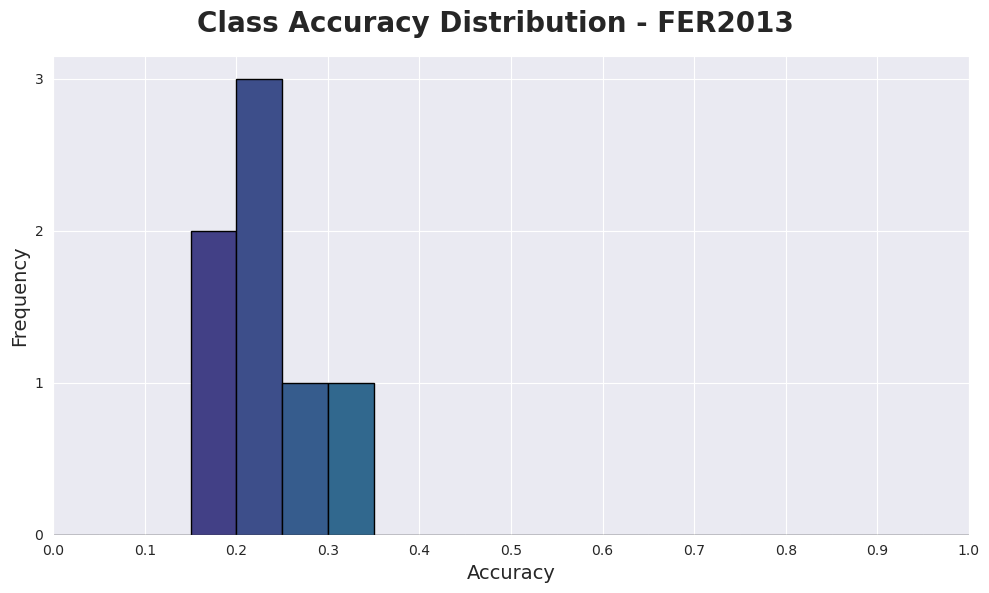

In [47]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [48]:
clip_pcam_1 = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
get_model_params(clip_pcam_1)

Parameters: 85.80M


In [50]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam_1,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 35.75it/s]


Epochs: 1/10 | train_loss: 0.6210 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 38.16it/s]


Epochs: 2/10 | train_loss: 0.5825 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.14it/s]


Epochs: 3/10 | train_loss: 0.5521 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 37.81it/s]


Epochs: 4/10 | train_loss: 0.5233 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.37it/s]


Epochs: 5/10 | train_loss: 0.4943 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Epochs: 6/10 | train_loss: 0.4658 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.38it/s]


Epochs: 7/10 | train_loss: 0.4389 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epochs: 8/10 | train_loss: 0.4138 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.01it/s]


Epochs: 9/10 | train_loss: 0.3903 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 38.24it/s]

Epochs: 10/10 | train_loss: 0.3682 | train_acc: 1.0000


In [51]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam_1,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:11<00:00, 11.03it/s]

test_loss: 0.6964 | test_acc: 0.5149


In [52]:
pcam_accs.append(pcam_acc)

In [53]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.6401073759990239,
 'lymph node tumor tissue': 0.38950967820724186}

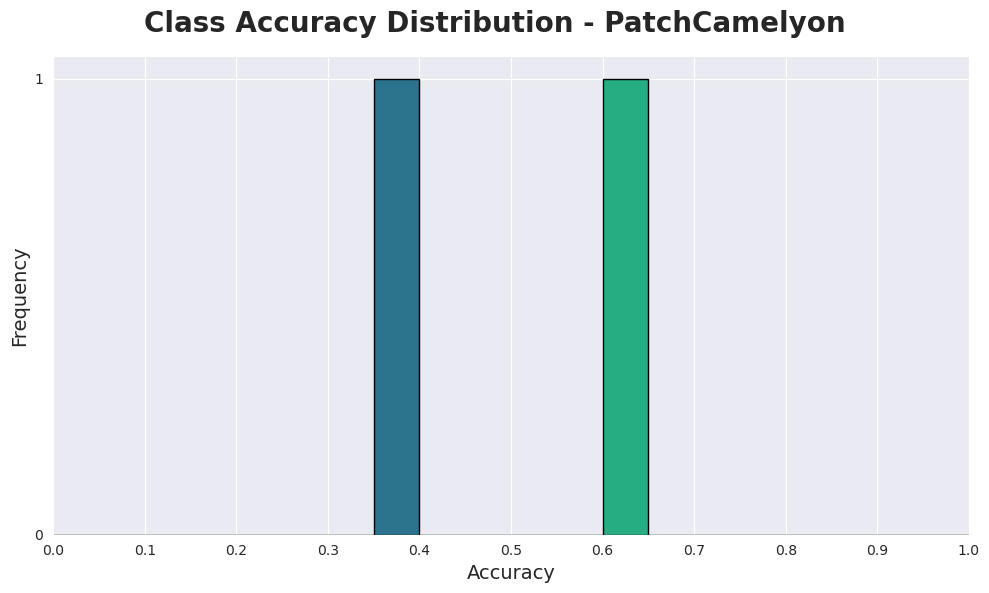

In [54]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [55]:
clip_sun397_1 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
get_model_params(clip_sun397_1)

Parameters: 86.10M


In [57]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397_1,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epochs: 1/10 | train_loss: 7.4562 | train_acc: 0.0000


100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


Epochs: 2/10 | train_loss: 5.5257 | train_acc: 0.1914


100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Epochs: 3/10 | train_loss: 4.5192 | train_acc: 0.6322


100%|██████████| 50/50 [00:05<00:00,  8.58it/s]


Epochs: 4/10 | train_loss: 3.6145 | train_acc: 0.9295


100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Epochs: 5/10 | train_loss: 2.7719 | train_acc: 0.9899


100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Epochs: 6/10 | train_loss: 2.0259 | train_acc: 0.9975


100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Epochs: 7/10 | train_loss: 1.4395 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


Epochs: 8/10 | train_loss: 1.0051 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


Epochs: 9/10 | train_loss: 0.7146 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]

Epochs: 10/10 | train_loss: 0.5154 | train_acc: 1.0000


In [58]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397_1,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:20<00:00,  8.49it/s]


test_loss: 3.5172 | test_acc: 0.3506


In [59]:
sun397_accs.append(sun397_acc)

In [60]:
get_top_5_accuracies(sun397_per_class_acc)

[('parking garage (indoor)', 1.0),
 ('sauna', 1.0),
 ('podium (outdoor)', 0.9545454545454546),
 ('cockpit', 0.9402985074626866),
 ('staduim (baseball)', 0.9272727272727272)]

In [61]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('arch', 0.0),
 ('castle', 0.0),
 ('courtyard', 0.0),
 ('gazebo (exterior)', 0.0),
 ('home office', 0.0)]

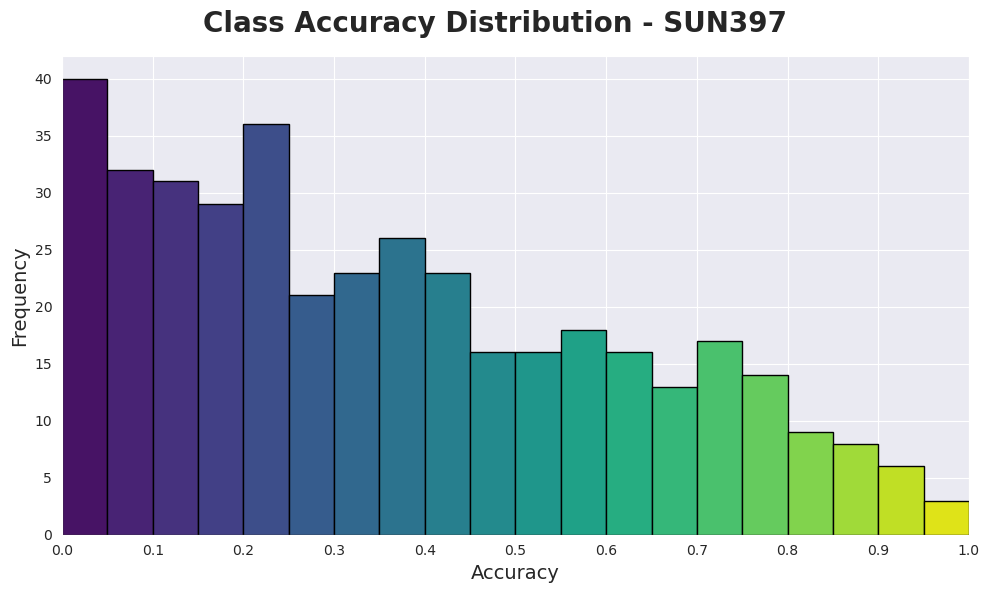

In [62]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [63]:
clip_dtd_1 = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
get_model_params(clip_dtd_1)

Parameters: 85.84M


In [65]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd_1,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00,  8.34it/s]


Epochs: 1/10 | train_loss: 4.1561 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00,  8.34it/s]


Epochs: 2/10 | train_loss: 3.6863 | train_acc: 0.1064


100%|██████████| 6/6 [00:00<00:00,  8.23it/s]


Epochs: 3/10 | train_loss: 3.3537 | train_acc: 0.4681


100%|██████████| 6/6 [00:00<00:00,  8.27it/s]


Epochs: 4/10 | train_loss: 3.0472 | train_acc: 0.8298


100%|██████████| 6/6 [00:00<00:00,  8.30it/s]


Epochs: 5/10 | train_loss: 2.7589 | train_acc: 0.9574


100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


Epochs: 6/10 | train_loss: 2.5020 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.30it/s]


Epochs: 7/10 | train_loss: 2.2385 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.23it/s]


Epochs: 8/10 | train_loss: 1.9943 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


Epochs: 9/10 | train_loss: 1.7818 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]

Epochs: 10/10 | train_loss: 1.5737 | train_acc: 1.0000


In [66]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd_1,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.57it/s]

test_loss: 3.1823 | test_acc: 0.3798


In [67]:
dtd_accs.append(dtd_acc)

In [68]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.95),
 ('paisley', 0.95),
 ('crystalline', 0.825),
 ('potholed', 0.8),
 ('stratified', 0.775)]

In [69]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('grooved', 0.0),
 ('knitted', 0.0),
 ('waffled', 0.0),
 ('crosshatched', 0.025),
 ('gauzy', 0.025)]

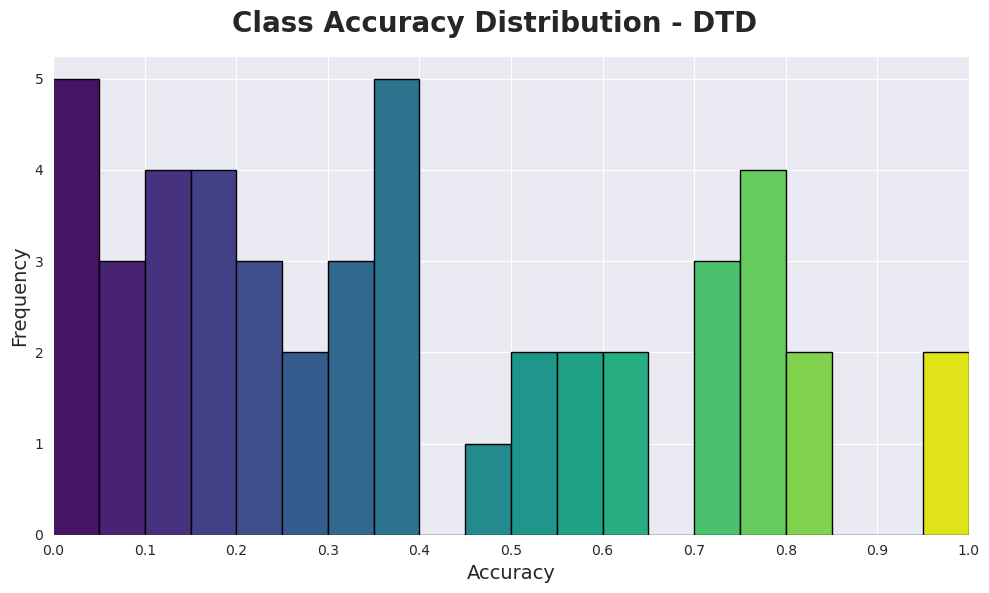

In [70]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=2)


Model is shown only 2 images per class from the dataset.

#### RESISC45

In [71]:
clip_resisc45_2 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
get_model_params(clip_resisc45_2)

Parameters: 85.83M


In [73]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45_2,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:01<00:00, 11.08it/s]


Epochs: 1/10 | train_loss: 4.1149 | train_acc: 0.0111


100%|██████████| 12/12 [00:01<00:00, 11.04it/s]


Epochs: 2/10 | train_loss: 3.4969 | train_acc: 0.2222


100%|██████████| 12/12 [00:01<00:00, 11.13it/s]


Epochs: 3/10 | train_loss: 3.1488 | train_acc: 0.6556


100%|██████████| 12/12 [00:01<00:00, 11.07it/s]


Epochs: 4/10 | train_loss: 2.8130 | train_acc: 0.8444


100%|██████████| 12/12 [00:01<00:00, 11.14it/s]


Epochs: 5/10 | train_loss: 2.5382 | train_acc: 0.9222


100%|██████████| 12/12 [00:01<00:00, 11.02it/s]


Epochs: 6/10 | train_loss: 2.2542 | train_acc: 0.9778


100%|██████████| 12/12 [00:01<00:00, 11.03it/s]


Epochs: 7/10 | train_loss: 2.0459 | train_acc: 0.9444


100%|██████████| 12/12 [00:01<00:00, 11.15it/s]


Epochs: 8/10 | train_loss: 1.7725 | train_acc: 0.9667


100%|██████████| 12/12 [00:01<00:00, 11.11it/s]


Epochs: 9/10 | train_loss: 1.6133 | train_acc: 0.9889


100%|██████████| 12/12 [00:01<00:00, 11.11it/s]

Epochs: 10/10 | train_loss: 1.4773 | train_acc: 0.9778


In [74]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45_2,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:15<00:00, 10.44it/s]

test_loss: 2.2698 | test_acc: 0.5851


In [75]:
resisc45_accs.append(resisc45_acc)

In [76]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9735099337748344),
 ('golf course', 0.9590163934426229),
 ('ship', 0.9481481481481482),
 ('mountain', 0.9478260869565217),
 ('overpass', 0.84)]

In [77]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('church', 0.02097902097902098),
 ('palace', 0.03571428571428571),
 ('dense residential', 0.06944444444444445),
 ('basketball court', 0.1044776119402985),
 ('roundabout', 0.14925373134328357)]

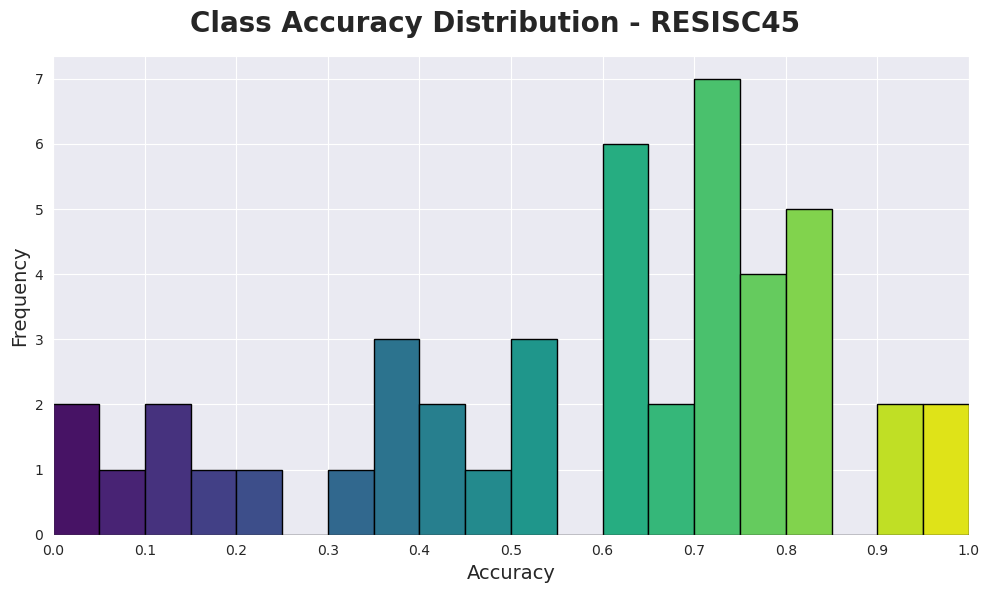

In [78]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [79]:
clip_food101_2 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
get_model_params(clip_food101_2)

Parameters: 85.88M


In [81]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101_2,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 26/26 [00:02<00:00,  8.86it/s]


Epochs: 1/10 | train_loss: 5.1795 | train_acc: 0.0000


100%|██████████| 26/26 [00:02<00:00,  8.97it/s]


Epochs: 2/10 | train_loss: 4.3456 | train_acc: 0.1733


100%|██████████| 26/26 [00:02<00:00,  8.97it/s]


Epochs: 3/10 | train_loss: 3.8840 | train_acc: 0.4059


100%|██████████| 26/26 [00:02<00:00,  8.94it/s]


Epochs: 4/10 | train_loss: 3.4793 | train_acc: 0.6634


100%|██████████| 26/26 [00:02<00:00,  8.86it/s]


Epochs: 5/10 | train_loss: 3.0994 | train_acc: 0.8416


100%|██████████| 26/26 [00:02<00:00,  8.93it/s]


Epochs: 6/10 | train_loss: 2.7494 | train_acc: 0.9158


100%|██████████| 26/26 [00:02<00:00,  8.93it/s]


Epochs: 7/10 | train_loss: 2.4407 | train_acc: 0.9208


100%|██████████| 26/26 [00:02<00:00,  8.91it/s]


Epochs: 8/10 | train_loss: 2.1493 | train_acc: 0.9851


100%|██████████| 26/26 [00:02<00:00,  9.02it/s]


Epochs: 9/10 | train_loss: 1.9012 | train_acc: 0.9505


100%|██████████| 26/26 [00:02<00:00,  8.98it/s]

Epochs: 10/10 | train_loss: 1.6592 | train_acc: 1.0000


In [82]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101_2,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [06:02<00:00,  8.72it/s]


test_loss: 2.8356 | test_acc: 0.5352


In [83]:
food101_accs.append(food101_acc)

In [84]:
get_top_5_accuracies(food101_per_class_acc)

[('oysters', 0.964),
 ('edamame', 0.956),
 ('guacamole', 0.948),
 ('pizza', 0.94),
 ('greek salad', 0.904)]

In [85]:
get_bottom_5_accuracies(food101_per_class_acc)

[('churros', 0.04),
 ('nachos', 0.052),
 ('cheesecake', 0.06),
 ('carrot cake', 0.072),
 ('crab cakes', 0.088)]

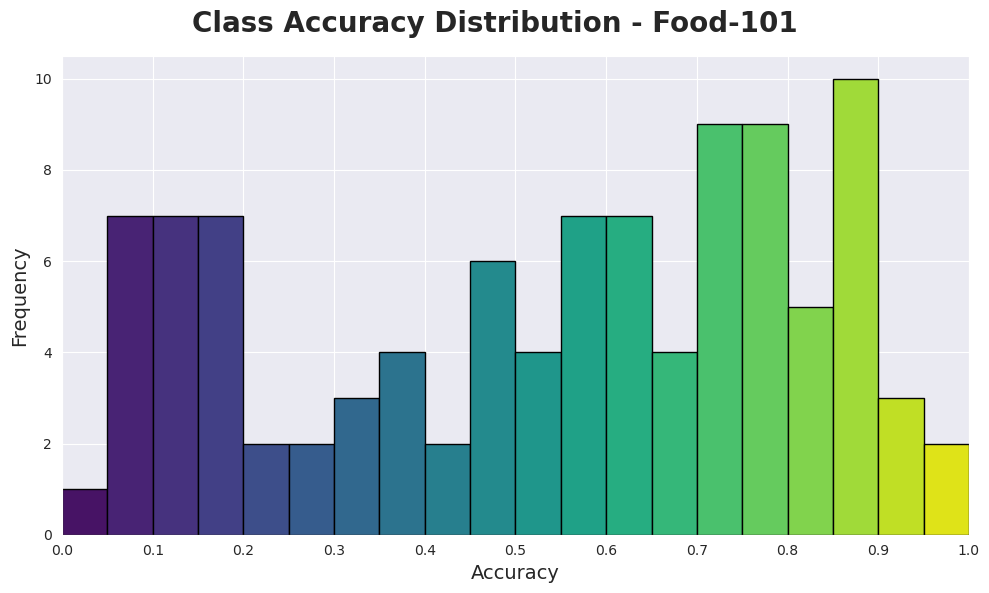

In [86]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [87]:
clip_fer2013_2 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
get_model_params(clip_fer2013_2)

Parameters: 85.80M


In [89]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013_2,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


Epochs: 1/10 | train_loss: 2.0403 | train_acc: 0.0000


100%|██████████| 2/2 [00:00<00:00, 12.45it/s]


Epochs: 2/10 | train_loss: 1.8841 | train_acc: 0.1429


100%|██████████| 2/2 [00:00<00:00, 12.07it/s]


Epochs: 3/10 | train_loss: 1.7695 | train_acc: 0.5000


100%|██████████| 2/2 [00:00<00:00, 12.45it/s]


Epochs: 4/10 | train_loss: 1.6874 | train_acc: 0.6429


100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


Epochs: 5/10 | train_loss: 1.5634 | train_acc: 0.7857


100%|██████████| 2/2 [00:00<00:00, 12.37it/s]


Epochs: 6/10 | train_loss: 1.4745 | train_acc: 0.8571


100%|██████████| 2/2 [00:00<00:00, 12.39it/s]


Epochs: 7/10 | train_loss: 1.4059 | train_acc: 0.8571


100%|██████████| 2/2 [00:00<00:00, 12.38it/s]


Epochs: 8/10 | train_loss: 1.2964 | train_acc: 0.9286


100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


Epochs: 9/10 | train_loss: 1.2371 | train_acc: 0.9286


100%|██████████| 2/2 [00:00<00:00, 12.48it/s]

Epochs: 10/10 | train_loss: 1.1282 | train_acc: 0.9286


In [90]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013_2,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:40<00:00, 11.18it/s]

test_loss: 1.9074 | test_acc: 0.2006


In [91]:
fer2013_accs.append(fer2013_acc)

In [92]:
fer2013_per_class_acc

{'angry': 0.13441955193482688,
 'disgust': 0.3090909090909091,
 'fear': 0.041666666666666664,
 'happy': 0.27986348122866894,
 'sad': 0.3114478114478115,
 'surprise': 0.1778846153846154,
 'neutral': 0.1757188498402556}

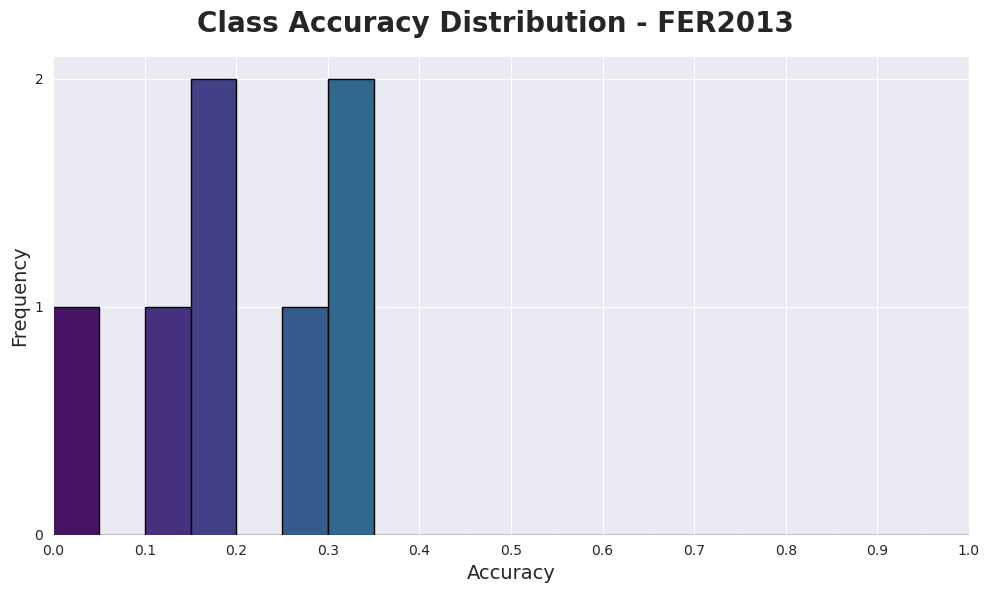

In [93]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [94]:
clip_pcam_2 = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
get_model_params(clip_pcam_2)

Parameters: 85.80M


In [96]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam_2,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epochs: 1/10 | train_loss: 0.6873 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epochs: 2/10 | train_loss: 0.6579 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epochs: 3/10 | train_loss: 0.6382 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epochs: 4/10 | train_loss: 0.6179 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epochs: 5/10 | train_loss: 0.5957 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epochs: 6/10 | train_loss: 0.5735 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epochs: 7/10 | train_loss: 0.5525 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Epochs: 8/10 | train_loss: 0.5329 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epochs: 9/10 | train_loss: 0.5143 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 20.17it/s]

Epochs: 10/10 | train_loss: 0.4960 | train_acc: 1.0000


In [97]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam_2,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:10<00:00, 11.04it/s]

test_loss: 0.6734 | test_acc: 0.5531


In [98]:
pcam_accs.append(pcam_acc)

In [99]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.5748276493197486,
 'lymph node tumor tissue': 0.5314160102582891}

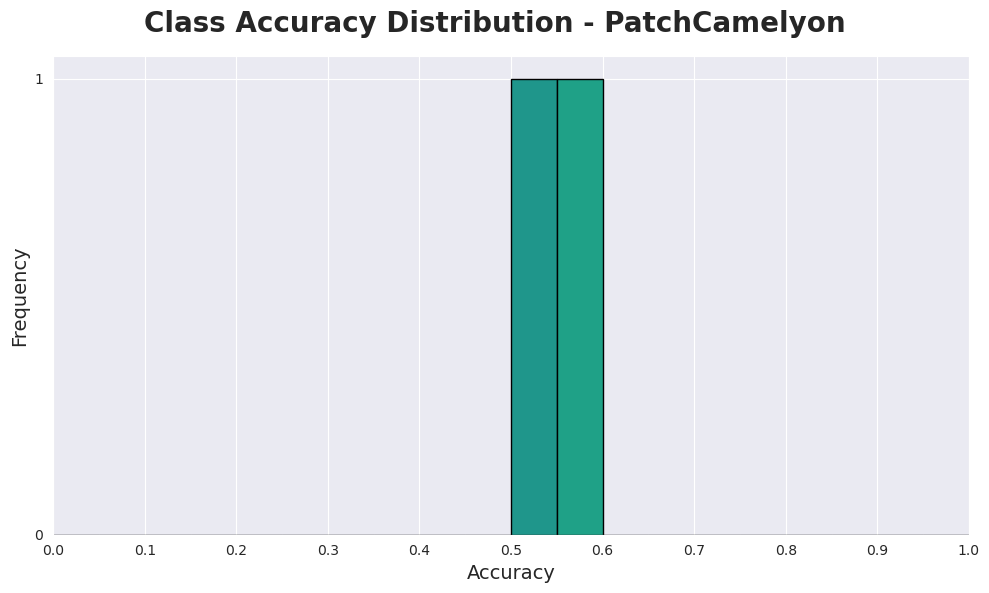

In [100]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [101]:
clip_sun397_2 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
get_model_params(clip_sun397_2)

Parameters: 86.10M


In [103]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397_2,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epochs: 1/10 | train_loss: 7.0147 | train_acc: 0.0038


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


Epochs: 2/10 | train_loss: 5.0866 | train_acc: 0.2015


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


Epochs: 3/10 | train_loss: 4.0333 | train_acc: 0.5088


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epochs: 4/10 | train_loss: 3.0836 | train_acc: 0.7657


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epochs: 5/10 | train_loss: 2.2986 | train_acc: 0.9131


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epochs: 6/10 | train_loss: 1.6659 | train_acc: 0.9534


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


Epochs: 7/10 | train_loss: 1.2204 | train_acc: 0.9874


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epochs: 8/10 | train_loss: 0.8871 | train_acc: 0.9924


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


Epochs: 9/10 | train_loss: 0.6616 | train_acc: 0.9987


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]

Epochs: 10/10 | train_loss: 0.4993 | train_acc: 0.9987


In [104]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397_2,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:20<00:00,  8.48it/s]


test_loss: 2.5970 | test_acc: 0.4792


In [105]:
sun397_accs.append(sun397_acc)

In [106]:
get_top_5_accuracies(sun397_per_class_acc)

[('sauna', 1.0),
 ('oilrig', 0.9666666666666667),
 ('watering hole', 0.9642857142857143),
 ('wine cellar (barrel storage)', 0.9607843137254902),
 ('track (outdoor)', 0.96)]

In [107]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('palace', 0.0),
 ('park', 0.0),
 ('sushi bar', 0.0),
 ('building facade', 0.013888888888888888),
 ('alley', 0.016666666666666666)]

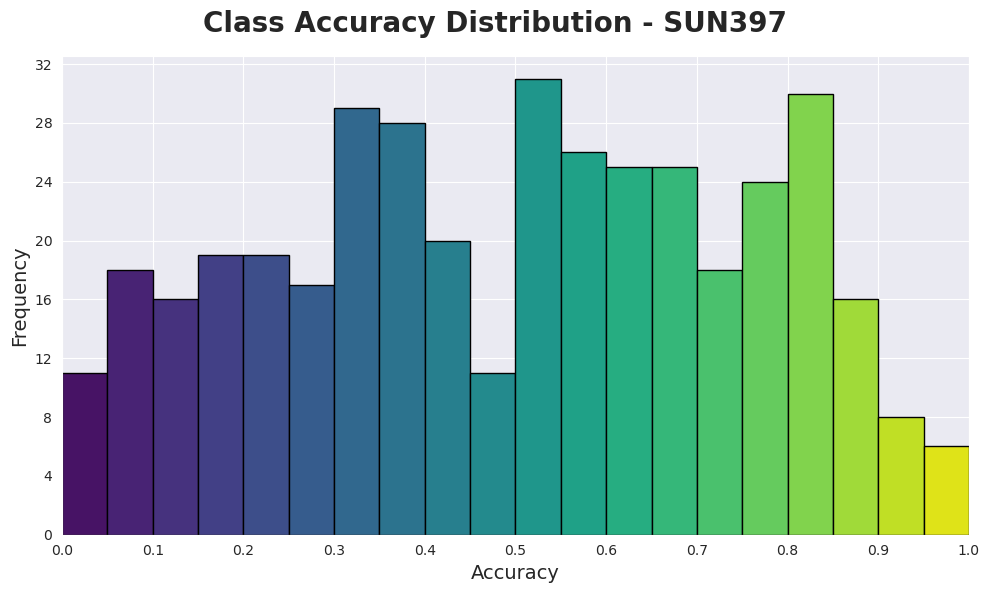

In [108]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [109]:
clip_dtd_2 = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
get_model_params(clip_dtd_2)

Parameters: 85.84M


In [111]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd_2,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epochs: 1/10 | train_loss: 4.1256 | train_acc: 0.0106


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epochs: 2/10 | train_loss: 3.5432 | train_acc: 0.2021


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epochs: 3/10 | train_loss: 3.1692 | train_acc: 0.6702


100%|██████████| 12/12 [00:01<00:00,  8.17it/s]


Epochs: 4/10 | train_loss: 2.8366 | train_acc: 0.9043


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epochs: 5/10 | train_loss: 2.5206 | train_acc: 0.9787


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epochs: 6/10 | train_loss: 2.2191 | train_acc: 0.9894


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epochs: 7/10 | train_loss: 1.9495 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epochs: 8/10 | train_loss: 1.7088 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epochs: 9/10 | train_loss: 1.5097 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

Epochs: 10/10 | train_loss: 1.3093 | train_acc: 1.0000


In [112]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd_2,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.63it/s]

test_loss: 2.7015 | test_acc: 0.4755


In [113]:
dtd_accs.append(dtd_acc)

In [114]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.95),
 ('chequered', 0.875),
 ('cobwebbed', 0.875),
 ('paisley', 0.875),
 ('polka-dotted', 0.875)]

In [115]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('flecked', 0.0),
 ('grooved', 0.025),
 ('blotchy', 0.05),
 ('honeycombed', 0.075),
 ('zigzagged', 0.1)]

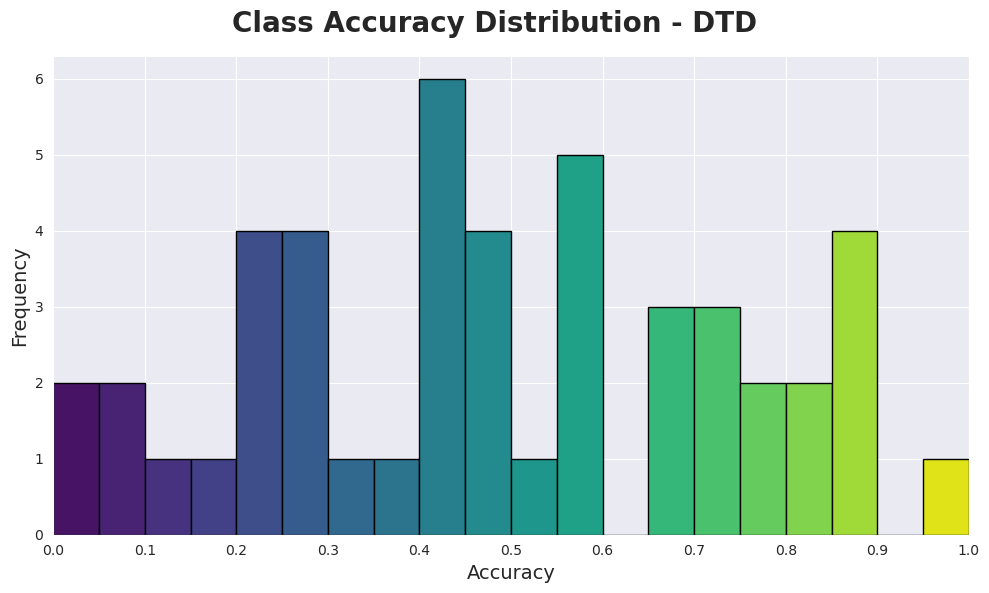

In [116]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=4)


Model is shown only 4 images per class from the dataset.

#### RESISC45

In [117]:
clip_resisc45_4 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [118]:
get_model_params(clip_resisc45_4)

Parameters: 85.83M


In [119]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45_4,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 23/23 [00:02<00:00, 10.48it/s]


Epochs: 1/10 | train_loss: 4.0098 | train_acc: 0.0333


100%|██████████| 23/23 [00:02<00:00, 10.56it/s]


Epochs: 2/10 | train_loss: 3.2668 | train_acc: 0.4167


100%|██████████| 23/23 [00:02<00:00, 10.52it/s]


Epochs: 3/10 | train_loss: 2.8090 | train_acc: 0.6889


100%|██████████| 23/23 [00:02<00:00, 10.56it/s]


Epochs: 4/10 | train_loss: 2.4133 | train_acc: 0.7389


100%|██████████| 23/23 [00:02<00:00, 10.56it/s]


Epochs: 5/10 | train_loss: 2.0543 | train_acc: 0.8389


100%|██████████| 23/23 [00:02<00:00, 10.54it/s]


Epochs: 6/10 | train_loss: 1.7742 | train_acc: 0.9056


100%|██████████| 23/23 [00:02<00:00, 10.46it/s]


Epochs: 7/10 | train_loss: 1.5289 | train_acc: 0.9333


100%|██████████| 23/23 [00:02<00:00, 10.54it/s]


Epochs: 8/10 | train_loss: 1.3178 | train_acc: 0.9556


100%|██████████| 23/23 [00:02<00:00, 10.50it/s]


Epochs: 9/10 | train_loss: 1.1662 | train_acc: 0.9611


100%|██████████| 23/23 [00:02<00:00, 10.57it/s]

Epochs: 10/10 | train_loss: 1.0285 | train_acc: 0.9722


In [120]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45_4,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:15<00:00, 10.38it/s]

test_loss: 1.5802 | test_acc: 0.7316


In [121]:
resisc45_accs.append(resisc45_acc)

In [122]:
get_top_5_accuracies(resisc45_per_class_acc)

[('ship', 0.9777777777777777),
 ('golf course', 0.9672131147540983),
 ('sea ice', 0.9536423841059603),
 ('snowberg', 0.9371069182389937),
 ('beach', 0.9230769230769231)]

In [123]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('tennis court', 0.09722222222222222),
 ('basketball court', 0.30597014925373134),
 ('palace', 0.35714285714285715),
 ('railway station', 0.37662337662337664),
 ('roundabout', 0.417910447761194)]

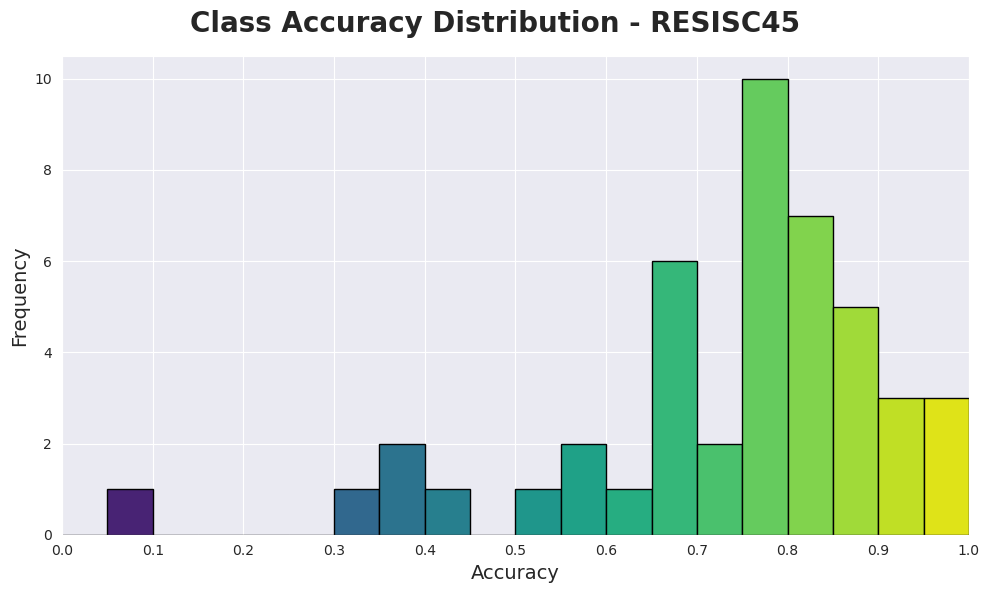

In [124]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [125]:
clip_food101_4 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
get_model_params(clip_food101_4)

Parameters: 85.88M


In [127]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101_4,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 51/51 [00:05<00:00,  8.78it/s]


Epochs: 1/10 | train_loss: 4.9814 | train_acc: 0.0198


100%|██████████| 51/51 [00:05<00:00,  8.89it/s]


Epochs: 2/10 | train_loss: 4.0491 | train_acc: 0.2450


100%|██████████| 51/51 [00:05<00:00,  8.92it/s]


Epochs: 3/10 | train_loss: 3.5123 | train_acc: 0.4752


100%|██████████| 51/51 [00:05<00:00,  8.84it/s]


Epochs: 4/10 | train_loss: 3.0365 | train_acc: 0.5743


100%|██████████| 51/51 [00:05<00:00,  8.82it/s]


Epochs: 5/10 | train_loss: 2.6014 | train_acc: 0.7772


100%|██████████| 51/51 [00:05<00:00,  8.81it/s]


Epochs: 6/10 | train_loss: 2.2173 | train_acc: 0.8614


100%|██████████| 51/51 [00:05<00:00,  8.85it/s]


Epochs: 7/10 | train_loss: 1.8979 | train_acc: 0.8886


100%|██████████| 51/51 [00:05<00:00,  8.91it/s]


Epochs: 8/10 | train_loss: 1.6414 | train_acc: 0.9381


100%|██████████| 51/51 [00:05<00:00,  8.86it/s]


Epochs: 9/10 | train_loss: 1.4217 | train_acc: 0.9554


100%|██████████| 51/51 [00:05<00:00,  8.87it/s]

Epochs: 10/10 | train_loss: 1.2369 | train_acc: 0.9579


In [128]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101_4,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [06:01<00:00,  8.74it/s]


test_loss: 2.0781 | test_acc: 0.6465


In [129]:
food101_accs.append(food101_acc)

In [130]:
get_top_5_accuracies(food101_per_class_acc)

[('oysters', 0.968),
 ('edamame', 0.964),
 ('pad thai', 0.956),
 ('donuts', 0.944),
 ('french fries', 0.944)]

In [131]:
get_bottom_5_accuracies(food101_per_class_acc)

[('grilled salmon', 0.112),
 ('gnocchi', 0.128),
 ('beet salad', 0.184),
 ('steak', 0.196),
 ('crab cakes', 0.2)]

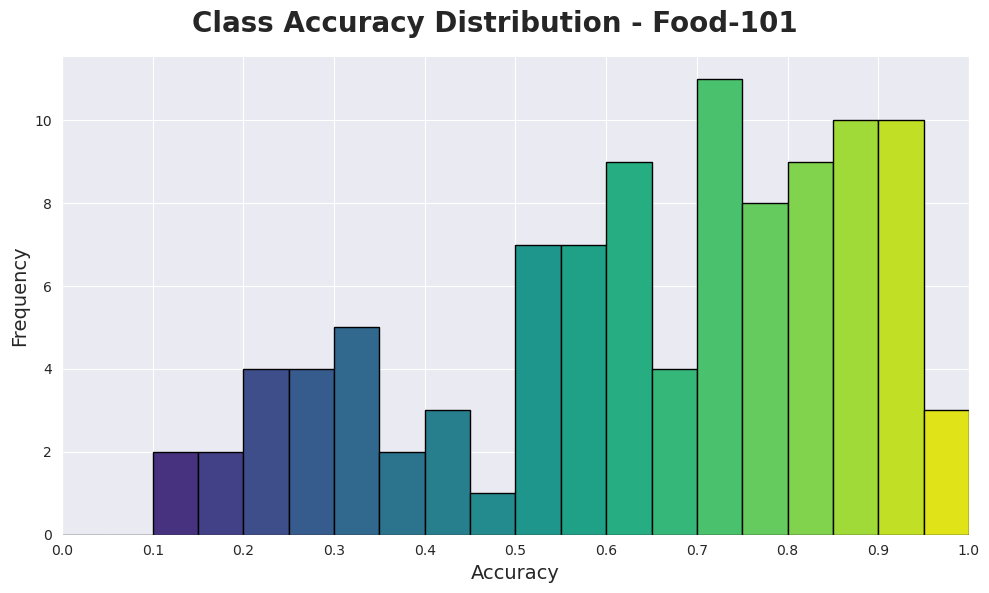

In [132]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [133]:
clip_fer2013_4 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [134]:
get_model_params(clip_fer2013_4)

Parameters: 85.80M


In [135]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013_4,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 4/4 [00:00<00:00, 12.43it/s]


Epochs: 1/10 | train_loss: 2.0082 | train_acc: 0.2143


100%|██████████| 4/4 [00:00<00:00, 12.56it/s]


Epochs: 2/10 | train_loss: 1.8303 | train_acc: 0.3214


100%|██████████| 4/4 [00:00<00:00, 12.47it/s]


Epochs: 3/10 | train_loss: 1.7222 | train_acc: 0.5000


100%|██████████| 4/4 [00:00<00:00, 12.49it/s]


Epochs: 4/10 | train_loss: 1.6292 | train_acc: 0.7500


100%|██████████| 4/4 [00:00<00:00, 12.56it/s]


Epochs: 5/10 | train_loss: 1.5158 | train_acc: 0.7857


100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


Epochs: 6/10 | train_loss: 1.4033 | train_acc: 0.8214


100%|██████████| 4/4 [00:00<00:00, 12.50it/s]


Epochs: 7/10 | train_loss: 1.3277 | train_acc: 0.8929


100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Epochs: 8/10 | train_loss: 1.2481 | train_acc: 0.9286


100%|██████████| 4/4 [00:00<00:00, 12.47it/s]


Epochs: 9/10 | train_loss: 1.1855 | train_acc: 0.9286


100%|██████████| 4/4 [00:00<00:00, 12.34it/s]

Epochs: 10/10 | train_loss: 1.1085 | train_acc: 1.0000


In [136]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013_4,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:40<00:00, 11.17it/s]

test_loss: 1.8518 | test_acc: 0.2622


In [137]:
fer2013_accs.append(fer2013_acc)

In [138]:
fer2013_per_class_acc

{'angry': 0.19144602851323828,
 'disgust': 0.34545454545454546,
 'fear': 0.26325757575757575,
 'happy': 0.4050056882821388,
 'sad': 0.3400673400673401,
 'surprise': 0.09375,
 'neutral': 0.14696485623003194}

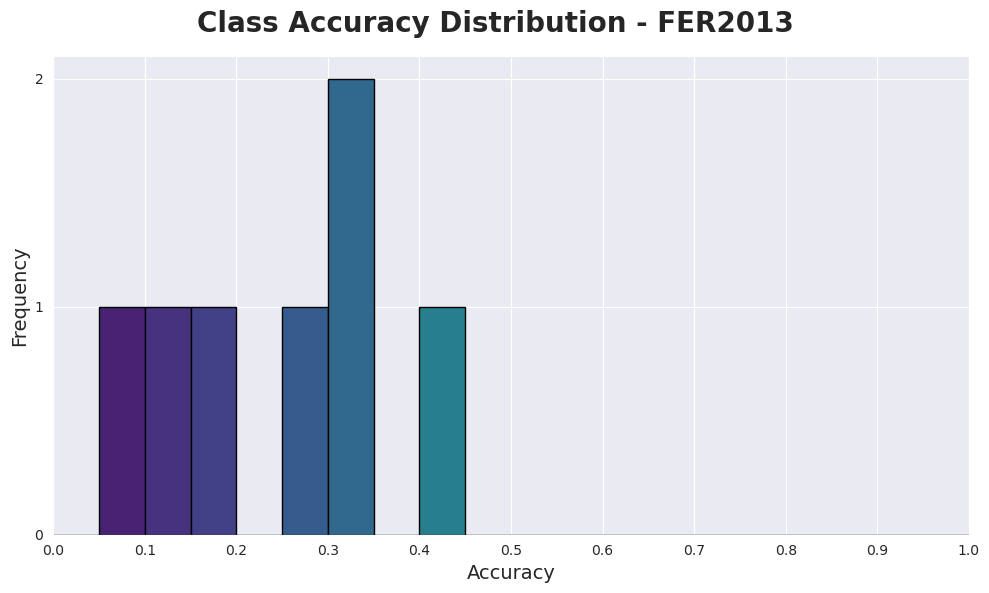

In [139]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [140]:
clip_pcam_4 = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [141]:
get_model_params(clip_pcam_4)

Parameters: 85.80M


In [142]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam_4,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


Epochs: 1/10 | train_loss: 0.7389 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Epochs: 2/10 | train_loss: 0.7070 | train_acc: 0.6250


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Epochs: 3/10 | train_loss: 0.6952 | train_acc: 0.3750


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Epochs: 4/10 | train_loss: 0.6865 | train_acc: 0.3750


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Epochs: 5/10 | train_loss: 0.6735 | train_acc: 0.3750


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epochs: 6/10 | train_loss: 0.6575 | train_acc: 0.3750


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Epochs: 7/10 | train_loss: 0.6415 | train_acc: 0.6250


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Epochs: 8/10 | train_loss: 0.6275 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


Epochs: 9/10 | train_loss: 0.6157 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

Epochs: 10/10 | train_loss: 0.6047 | train_acc: 0.7500


In [143]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam_4,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:10<00:00, 11.05it/s]

test_loss: 0.6764 | test_acc: 0.6385


In [144]:
pcam_accs.append(pcam_acc)

In [145]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.3649563785003966,
 'lymph node tumor tissue': 0.9123771142455883}

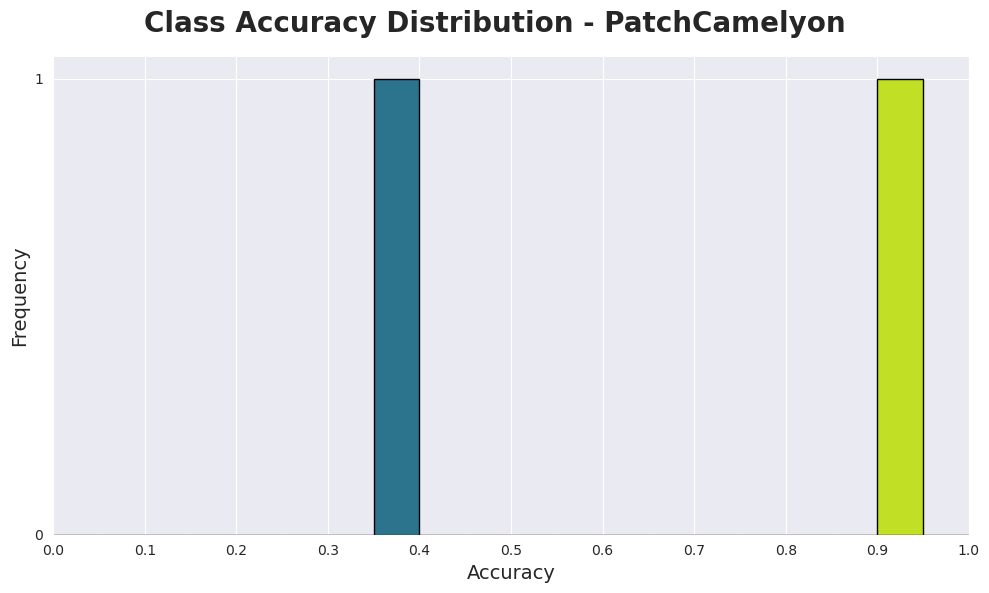

In [146]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [147]:
clip_sun397_4 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [148]:
get_model_params(clip_sun397_4)

Parameters: 86.10M


In [149]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397_4,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 199/199 [00:24<00:00,  8.29it/s]


Epochs: 1/10 | train_loss: 6.3584 | train_acc: 0.0290


100%|██████████| 199/199 [00:23<00:00,  8.54it/s]


Epochs: 2/10 | train_loss: 4.3244 | train_acc: 0.3060


100%|██████████| 199/199 [00:23<00:00,  8.56it/s]


Epochs: 3/10 | train_loss: 3.0781 | train_acc: 0.5938


100%|██████████| 199/199 [00:23<00:00,  8.55it/s]


Epochs: 4/10 | train_loss: 2.1693 | train_acc: 0.7576


100%|██████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 5/10 | train_loss: 1.5316 | train_acc: 0.8722


100%|██████████| 199/199 [00:23<00:00,  8.54it/s]


Epochs: 6/10 | train_loss: 1.1200 | train_acc: 0.9232


100%|██████████| 199/199 [00:23<00:00,  8.54it/s]


Epochs: 7/10 | train_loss: 0.8374 | train_acc: 0.9547


100%|██████████| 199/199 [00:23<00:00,  8.54it/s]


Epochs: 8/10 | train_loss: 0.6344 | train_acc: 0.9729


100%|██████████| 199/199 [00:23<00:00,  8.55it/s]


Epochs: 9/10 | train_loss: 0.4886 | train_acc: 0.9824


100%|██████████| 199/199 [00:23<00:00,  8.55it/s]


Epochs: 10/10 | train_loss: 0.3846 | train_acc: 0.9924


In [150]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397_4,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:20<00:00,  8.48it/s]


test_loss: 1.9076 | test_acc: 0.5554


In [151]:
sun397_accs.append(sun397_acc)

In [152]:
get_top_5_accuracies(sun397_per_class_acc)

[('medina', 1.0),
 ('parking garage (indoor)', 1.0),
 ('sauna', 1.0),
 ('skatepark', 1.0),
 ('sky', 0.9743589743589743)]

In [153]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bazaar (indoor)', 0.0),
 ('factory (indoor)', 0.0),
 ('building facade', 0.027777777777777776),
 ('canyon', 0.05660377358490566),
 ('market (indoor)', 0.07142857142857142)]

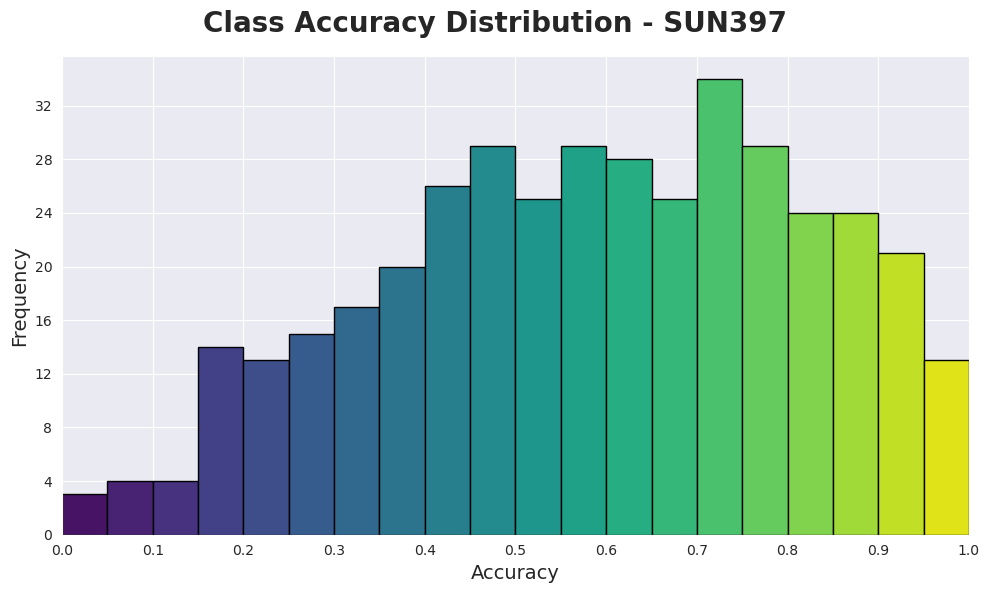

In [154]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [155]:
clip_dtd_4 = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [156]:
get_model_params(clip_dtd_4)

Parameters: 85.84M


In [157]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd_4,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 24/24 [00:02<00:00,  8.24it/s]


Epochs: 1/10 | train_loss: 4.0214 | train_acc: 0.0479


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]


Epochs: 2/10 | train_loss: 3.3727 | train_acc: 0.3351


100%|██████████| 24/24 [00:02<00:00,  8.26it/s]


Epochs: 3/10 | train_loss: 2.9080 | train_acc: 0.6809


100%|██████████| 24/24 [00:02<00:00,  8.26it/s]


Epochs: 4/10 | train_loss: 2.4936 | train_acc: 0.8085


100%|██████████| 24/24 [00:02<00:00,  8.26it/s]


Epochs: 5/10 | train_loss: 2.1151 | train_acc: 0.9043


100%|██████████| 24/24 [00:02<00:00,  8.34it/s]


Epochs: 6/10 | train_loss: 1.8060 | train_acc: 0.9149


100%|██████████| 24/24 [00:02<00:00,  8.30it/s]


Epochs: 7/10 | train_loss: 1.5534 | train_acc: 0.9309


100%|██████████| 24/24 [00:02<00:00,  8.31it/s]


Epochs: 8/10 | train_loss: 1.3420 | train_acc: 0.9574


100%|██████████| 24/24 [00:02<00:00,  8.40it/s]


Epochs: 9/10 | train_loss: 1.1465 | train_acc: 0.9681


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]

Epochs: 10/10 | train_loss: 1.0113 | train_acc: 0.9787


In [158]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd_4,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.61it/s]

test_loss: 2.1407 | test_acc: 0.5697


In [159]:
dtd_accs.append(dtd_acc)

In [160]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.975),
 ('zigzagged', 0.975),
 ('potholed', 0.95),
 ('bubbly', 0.925),
 ('cobwebbed', 0.925)]

In [161]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('flecked', 0.1),
 ('grooved', 0.1),
 ('bumpy', 0.175),
 ('gauzy', 0.2),
 ('blotchy', 0.225)]

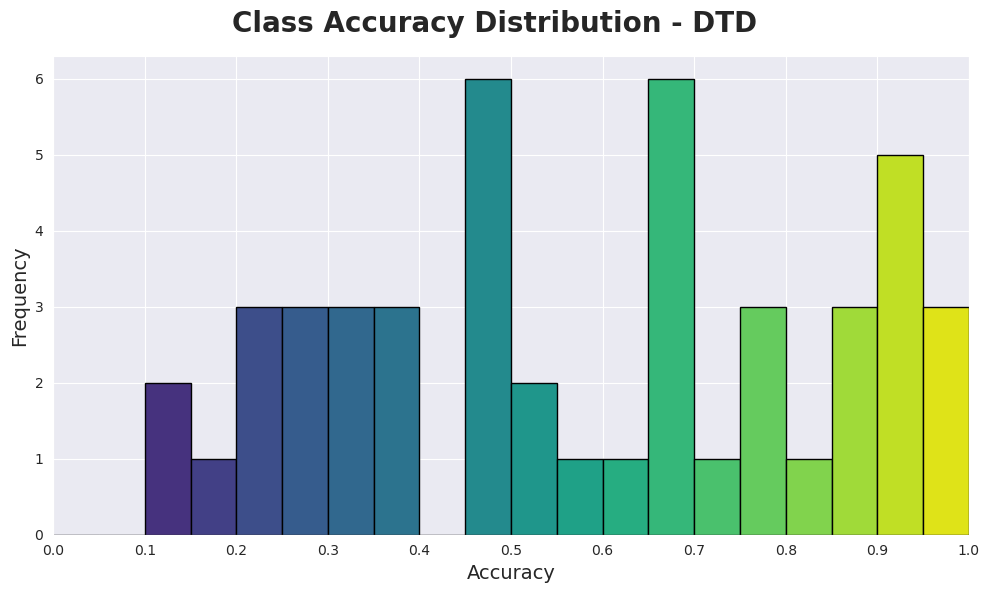

In [162]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=8)


Model is shown only 8 images per class from the dataset.

#### RESISC45

In [163]:
clip_resisc45_8 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [164]:
get_model_params(clip_resisc45_8)

Parameters: 85.83M


In [165]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45_8,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 45/45 [00:04<00:00, 10.39it/s]


Epochs: 1/10 | train_loss: 3.7591 | train_acc: 0.1111


100%|██████████| 45/45 [00:04<00:00, 10.45it/s]


Epochs: 2/10 | train_loss: 2.8115 | train_acc: 0.5611


100%|██████████| 45/45 [00:04<00:00, 10.47it/s]


Epochs: 3/10 | train_loss: 2.1933 | train_acc: 0.7167


100%|██████████| 45/45 [00:04<00:00, 10.48it/s]


Epochs: 4/10 | train_loss: 1.7321 | train_acc: 0.8083


100%|██████████| 45/45 [00:04<00:00, 10.48it/s]


Epochs: 5/10 | train_loss: 1.4059 | train_acc: 0.8639


100%|██████████| 45/45 [00:04<00:00, 10.47it/s]


Epochs: 6/10 | train_loss: 1.1682 | train_acc: 0.8861


100%|██████████| 45/45 [00:04<00:00, 10.47it/s]


Epochs: 7/10 | train_loss: 0.9993 | train_acc: 0.9028


100%|██████████| 45/45 [00:04<00:00, 10.45it/s]


Epochs: 8/10 | train_loss: 0.8596 | train_acc: 0.9139


100%|██████████| 45/45 [00:04<00:00, 10.46it/s]


Epochs: 9/10 | train_loss: 0.7644 | train_acc: 0.9250


100%|██████████| 45/45 [00:04<00:00, 10.47it/s]

Epochs: 10/10 | train_loss: 0.6730 | train_acc: 0.9306


In [166]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45_8,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:15<00:00, 10.47it/s]

test_loss: 1.0541 | test_acc: 0.7865


In [167]:
resisc45_accs.append(resisc45_acc)

In [168]:
get_top_5_accuracies(resisc45_per_class_acc)

[('snowberg', 0.9685534591194969),
 ('storage tank', 0.9562043795620438),
 ('ship', 0.9555555555555556),
 ('sea ice', 0.9536423841059603),
 ('golf course', 0.9508196721311475)]

In [169]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('tennis court', 0.4166666666666667),
 ('ground track field', 0.5118110236220472),
 ('basketball court', 0.5522388059701493),
 ('church', 0.5594405594405595),
 ('medium residential', 0.5850340136054422)]

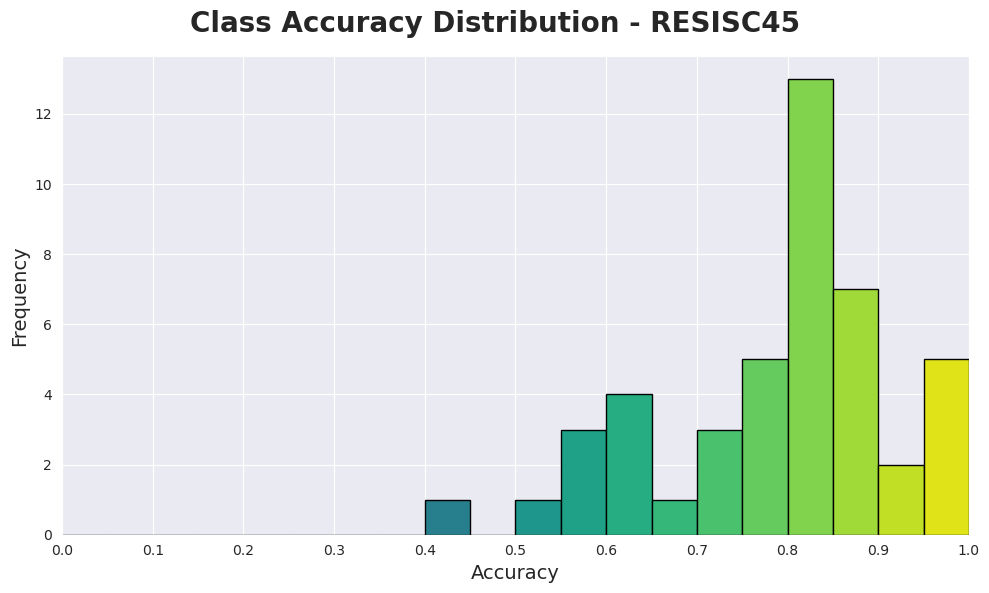

In [170]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [171]:
clip_food101_8 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [172]:
get_model_params(clip_food101_8)

Parameters: 85.88M


In [173]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101_8,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 101/101 [00:11<00:00,  8.74it/s]


Epochs: 1/10 | train_loss: 4.6833 | train_acc: 0.0656


100%|██████████| 101/101 [00:11<00:00,  8.78it/s]


Epochs: 2/10 | train_loss: 3.5654 | train_acc: 0.3354


100%|██████████| 101/101 [00:11<00:00,  8.67it/s]


Epochs: 3/10 | train_loss: 2.8479 | train_acc: 0.5582


100%|██████████| 101/101 [00:11<00:00,  8.76it/s]


Epochs: 4/10 | train_loss: 2.2858 | train_acc: 0.7240


100%|██████████| 101/101 [00:11<00:00,  8.81it/s]


Epochs: 5/10 | train_loss: 1.8751 | train_acc: 0.7970


100%|██████████| 101/101 [00:11<00:00,  8.79it/s]


Epochs: 6/10 | train_loss: 1.5813 | train_acc: 0.8403


100%|██████████| 101/101 [00:11<00:00,  8.75it/s]


Epochs: 7/10 | train_loss: 1.3337 | train_acc: 0.8639


100%|██████████| 101/101 [00:11<00:00,  8.79it/s]


Epochs: 8/10 | train_loss: 1.1494 | train_acc: 0.9035


100%|██████████| 101/101 [00:11<00:00,  8.75it/s]


Epochs: 9/10 | train_loss: 0.9893 | train_acc: 0.9121


100%|██████████| 101/101 [00:11<00:00,  8.79it/s]

Epochs: 10/10 | train_loss: 0.8579 | train_acc: 0.9319


In [174]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101_8,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:59<00:00,  8.79it/s]


test_loss: 1.4374 | test_acc: 0.7280


In [175]:
food101_accs.append(food101_acc)

In [176]:
get_top_5_accuracies(food101_per_class_acc)

[('donuts', 0.968),
 ('edamame', 0.968),
 ('oysters', 0.964),
 ('pad thai', 0.952),
 ('macarons', 0.94)]

In [177]:
get_bottom_5_accuracies(food101_per_class_acc)

[('bread pudding', 0.196),
 ('ravioli', 0.204),
 ('tuna tartare', 0.22),
 ('steak', 0.336),
 ('cheesecake', 0.34)]

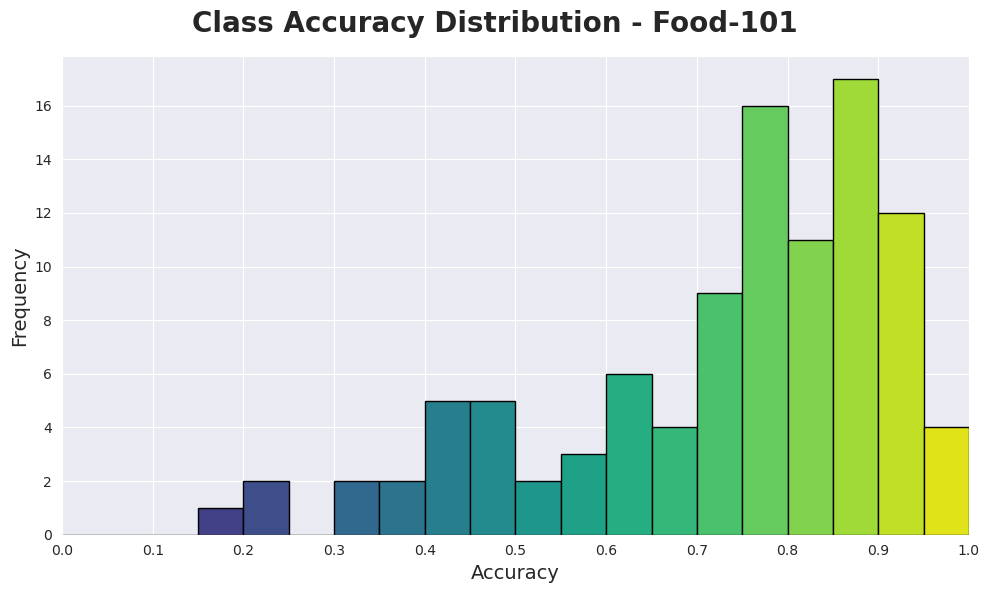

In [178]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [179]:
clip_fer2013_8 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [180]:
get_model_params(clip_fer2013_8)

Parameters: 85.80M


In [181]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013_8,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 7/7 [00:00<00:00, 11.07it/s]


Epochs: 1/10 | train_loss: 2.0642 | train_acc: 0.0893


100%|██████████| 7/7 [00:00<00:00, 10.98it/s]


Epochs: 2/10 | train_loss: 1.8490 | train_acc: 0.3214


100%|██████████| 7/7 [00:00<00:00, 11.05it/s]


Epochs: 3/10 | train_loss: 1.7372 | train_acc: 0.4464


100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Epochs: 4/10 | train_loss: 1.6473 | train_acc: 0.6071


100%|██████████| 7/7 [00:00<00:00, 11.10it/s]


Epochs: 5/10 | train_loss: 1.5540 | train_acc: 0.7321


100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Epochs: 6/10 | train_loss: 1.4696 | train_acc: 0.7679


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


Epochs: 7/10 | train_loss: 1.4063 | train_acc: 0.7679


100%|██████████| 7/7 [00:00<00:00, 11.06it/s]


Epochs: 8/10 | train_loss: 1.3168 | train_acc: 0.8571


100%|██████████| 7/7 [00:00<00:00, 11.10it/s]


Epochs: 9/10 | train_loss: 1.2446 | train_acc: 0.9107


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]

Epochs: 10/10 | train_loss: 1.1863 | train_acc: 0.9107


In [182]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013_8,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:40<00:00, 11.15it/s]

test_loss: 1.7800 | test_acc: 0.3215


In [183]:
fer2013_accs.append(fer2013_acc)

In [184]:
fer2013_per_class_acc

{'angry': 0.40529531568228105,
 'disgust': 0.38181818181818183,
 'fear': 0.17424242424242425,
 'happy': 0.3799772468714448,
 'sad': 0.30134680134680136,
 'surprise': 0.39663461538461536,
 'neutral': 0.26198083067092653}

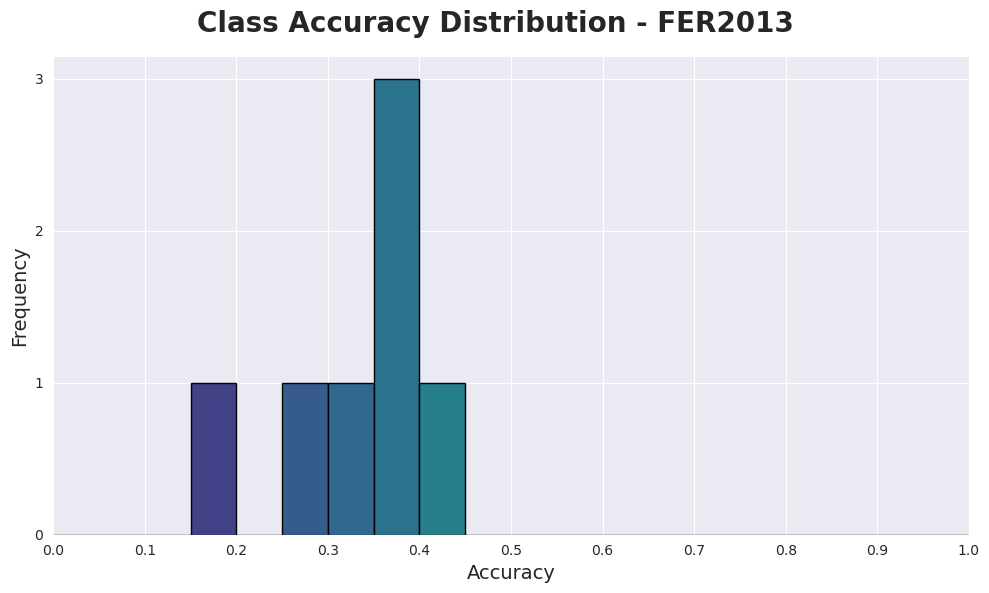

In [185]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [186]:
clip_pcam_8 = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [187]:
get_model_params(clip_pcam_8)

Parameters: 85.80M


In [188]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam_8,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


Epochs: 1/10 | train_loss: 0.7143 | train_acc: 0.3750


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


Epochs: 2/10 | train_loss: 0.6924 | train_acc: 0.5625


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


Epochs: 3/10 | train_loss: 0.6677 | train_acc: 0.5000


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


Epochs: 4/10 | train_loss: 0.6399 | train_acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


Epochs: 5/10 | train_loss: 0.6184 | train_acc: 0.9375


100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


Epochs: 6/10 | train_loss: 0.6064 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00, 11.01it/s]


Epochs: 7/10 | train_loss: 0.5903 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00, 11.01it/s]


Epochs: 8/10 | train_loss: 0.5833 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


Epochs: 9/10 | train_loss: 0.5604 | train_acc: 0.8750


100%|██████████| 2/2 [00:00<00:00, 10.97it/s]

Epochs: 10/10 | train_loss: 0.5455 | train_acc: 0.9375


In [189]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam_8,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:11<00:00, 11.02it/s]

test_loss: 0.6443 | test_acc: 0.6562


In [190]:
pcam_accs.append(pcam_acc)

In [191]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.6053321944969801,
 'lymph node tumor tissue': 0.7072113329669659}

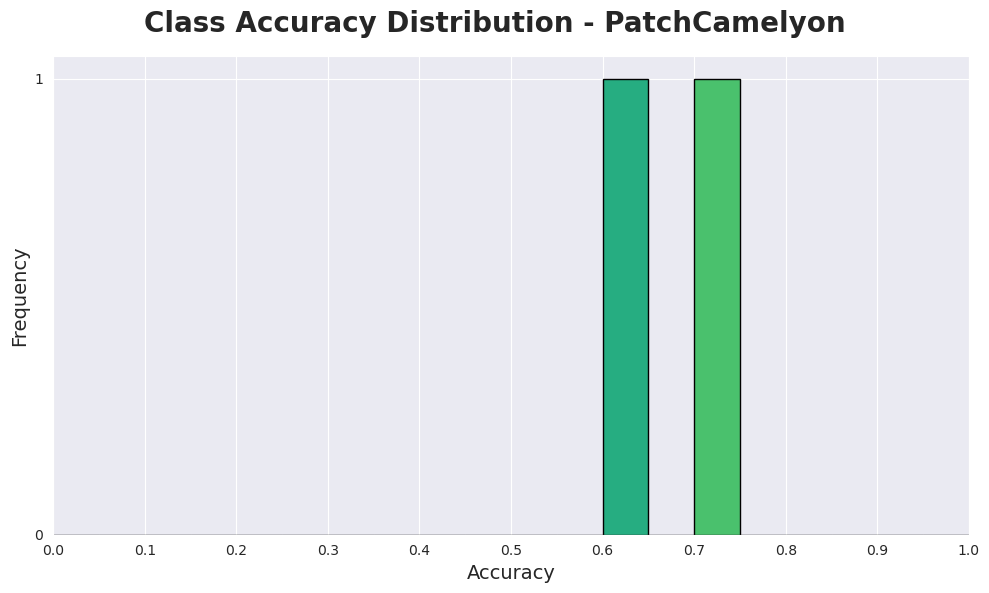

In [192]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [193]:
clip_sun397_8 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [194]:
get_model_params(clip_sun397_8)

Parameters: 86.10M


In [195]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397_8,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 397/397 [00:47<00:00,  8.34it/s]


Epochs: 1/10 | train_loss: 5.5142 | train_acc: 0.1108


100%|██████████| 397/397 [00:46<00:00,  8.53it/s]


Epochs: 2/10 | train_loss: 3.1685 | train_acc: 0.4657


100%|██████████| 397/397 [00:46<00:00,  8.52it/s]


Epochs: 3/10 | train_loss: 1.9940 | train_acc: 0.6785


100%|██████████| 397/397 [00:46<00:00,  8.54it/s]


Epochs: 4/10 | train_loss: 1.3724 | train_acc: 0.7991


100%|██████████| 397/397 [00:46<00:00,  8.52it/s]


Epochs: 5/10 | train_loss: 0.9951 | train_acc: 0.8536


100%|██████████| 397/397 [00:46<00:00,  8.54it/s]


Epochs: 6/10 | train_loss: 0.7600 | train_acc: 0.8952


100%|██████████| 397/397 [00:46<00:00,  8.52it/s]


Epochs: 7/10 | train_loss: 0.5869 | train_acc: 0.9314


 48%|████▊     | 192/397 [00:22<00:23,  8.61it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [196]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397_8,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:20<00:00,  8.49it/s]


test_loss: 1.4570 | test_acc: 0.6166


In [197]:
sun397_accs.append(sun397_acc)

In [198]:
get_top_5_accuracies(sun397_per_class_acc)

[('discotheque', 1.0),
 ('electrical substation', 1.0),
 ('parking garage (indoor)', 1.0),
 ('sauna', 1.0),
 ('skatepark', 1.0)]

In [199]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('restaurant', 0.0196078431372549),
 ('monastery (outdoor)', 0.06896551724137931),
 ('fairway', 0.10638297872340426),
 ('gift shop', 0.14285714285714285),
 ('house', 0.14492753623188406)]

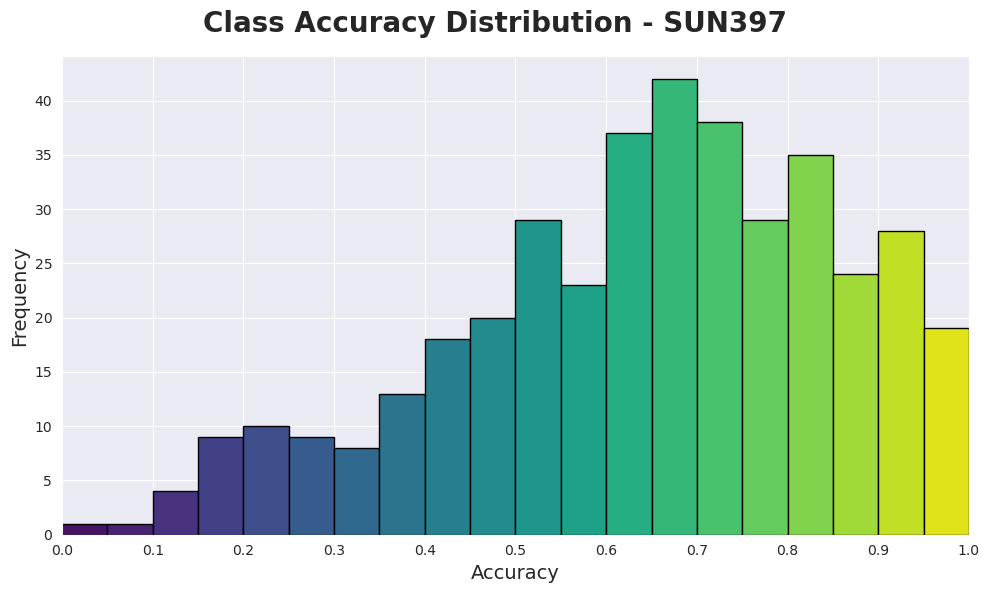

In [200]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [201]:
clip_dtd_8 = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [202]:
get_model_params(clip_dtd_8)

Parameters: 85.84M


In [203]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd_8,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 47/47 [00:05<00:00,  8.08it/s]


Epochs: 1/10 | train_loss: 3.8524 | train_acc: 0.1064


100%|██████████| 47/47 [00:05<00:00,  8.15it/s]


Epochs: 2/10 | train_loss: 2.9406 | train_acc: 0.5532


100%|██████████| 47/47 [00:05<00:00,  8.16it/s]


Epochs: 3/10 | train_loss: 2.3298 | train_acc: 0.6995


100%|██████████| 47/47 [00:05<00:00,  8.12it/s]


Epochs: 4/10 | train_loss: 1.8587 | train_acc: 0.8165


100%|██████████| 47/47 [00:05<00:00,  8.11it/s]


Epochs: 5/10 | train_loss: 1.5108 | train_acc: 0.8537


100%|██████████| 47/47 [00:05<00:00,  8.08it/s]


Epochs: 6/10 | train_loss: 1.2607 | train_acc: 0.8644


100%|██████████| 47/47 [00:05<00:00,  8.14it/s]


Epochs: 7/10 | train_loss: 1.0661 | train_acc: 0.8883


100%|██████████| 47/47 [00:05<00:00,  8.14it/s]


Epochs: 8/10 | train_loss: 0.9124 | train_acc: 0.9282


100%|██████████| 47/47 [00:05<00:00,  8.23it/s]


Epochs: 9/10 | train_loss: 0.7947 | train_acc: 0.9309


100%|██████████| 47/47 [00:05<00:00,  8.23it/s]

Epochs: 10/10 | train_loss: 0.6936 | train_acc: 0.9548


In [204]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd_8,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.67it/s]

test_loss: 1.6104 | test_acc: 0.6266


In [205]:
dtd_accs.append(dtd_acc)

In [206]:
get_top_5_accuracies(dtd_per_class_acc)

[('zigzagged', 1.0),
 ('crystalline', 0.975),
 ('knitted', 0.925),
 ('potholed', 0.925),
 ('lacelike', 0.9)]

In [207]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('flecked', 0.1),
 ('bumpy', 0.225),
 ('grooved', 0.225),
 ('porous', 0.225),
 ('woven', 0.25)]

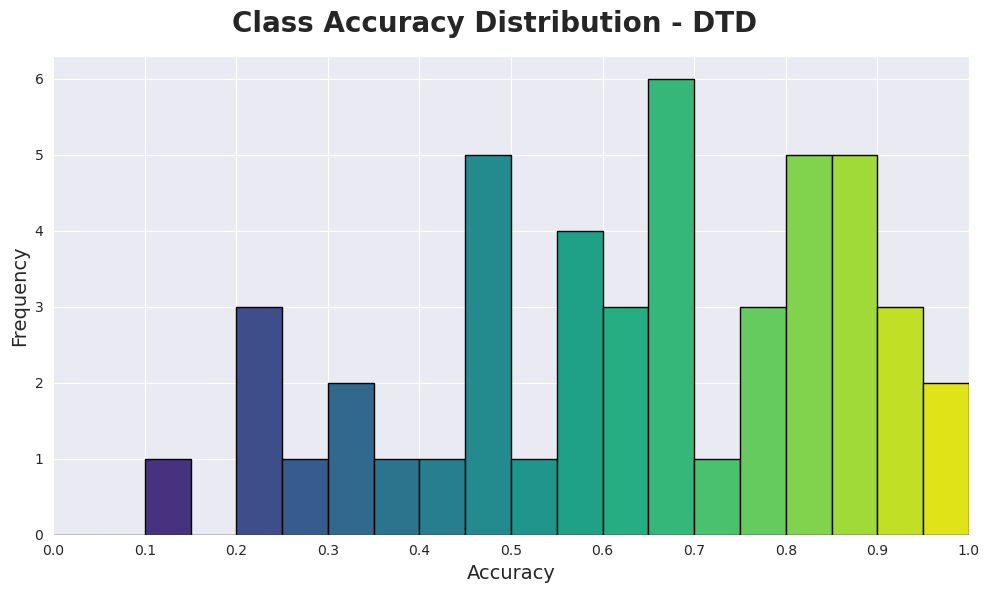

In [208]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=16)


Model is shown only 16 images per class from the dataset.

#### RESISC45

In [209]:
clip_resisc45_16 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [210]:
get_model_params(clip_resisc45_16)

Parameters: 85.83M


In [211]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45_16,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Epochs: 1/10 | train_loss: 3.3288 | train_acc: 0.2694


100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Epochs: 2/10 | train_loss: 2.0958 | train_acc: 0.6444


100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Epochs: 3/10 | train_loss: 1.4498 | train_acc: 0.7847


100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Epochs: 4/10 | train_loss: 1.1065 | train_acc: 0.8472


100%|██████████| 90/90 [00:08<00:00, 10.43it/s]


Epochs: 5/10 | train_loss: 0.8898 | train_acc: 0.8681


100%|██████████| 90/90 [00:08<00:00, 10.42it/s]


Epochs: 6/10 | train_loss: 0.7528 | train_acc: 0.8986


100%|██████████| 90/90 [00:08<00:00, 10.42it/s]


Epochs: 7/10 | train_loss: 0.6377 | train_acc: 0.9014


100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Epochs: 8/10 | train_loss: 0.5558 | train_acc: 0.9333


100%|██████████| 90/90 [00:08<00:00, 10.39it/s]


Epochs: 9/10 | train_loss: 0.4904 | train_acc: 0.9306


100%|██████████| 90/90 [00:08<00:00, 10.44it/s]

Epochs: 10/10 | train_loss: 0.4463 | train_acc: 0.9347


In [212]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45_16,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:15<00:00, 10.43it/s]

test_loss: 0.7225 | test_acc: 0.8214


In [213]:
resisc45_accs.append(resisc45_acc)

In [214]:
get_top_5_accuracies(resisc45_per_class_acc)

[('beach', 0.9692307692307692),
 ('sea ice', 0.9668874172185431),
 ('chaparral', 0.9621212121212122),
 ('golf course', 0.9590163934426229),
 ('ship', 0.9407407407407408)]

In [215]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.2357142857142857),
 ('tennis court', 0.5416666666666666),
 ('medium residential', 0.54421768707483),
 ('industrial area', 0.6214285714285714),
 ('roundabout', 0.6343283582089553)]

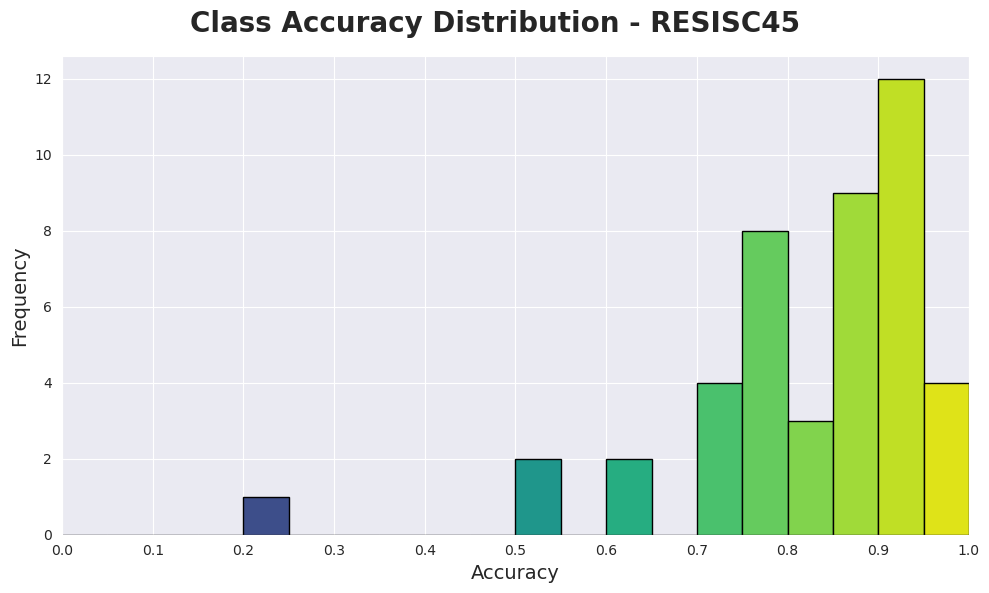

In [216]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [217]:
clip_food101_16 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [218]:
get_model_params(clip_food101_16)

Parameters: 85.88M


In [219]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101_16,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 202/202 [00:23<00:00,  8.73it/s]


Epochs: 1/10 | train_loss: 4.1785 | train_acc: 0.1473


100%|██████████| 202/202 [00:23<00:00,  8.75it/s]


Epochs: 2/10 | train_loss: 2.7952 | train_acc: 0.5229


100%|██████████| 202/202 [00:23<00:00,  8.66it/s]


Epochs: 3/10 | train_loss: 2.0275 | train_acc: 0.6894


100%|██████████| 202/202 [00:23<00:00,  8.71it/s]


Epochs: 4/10 | train_loss: 1.5774 | train_acc: 0.7556


100%|██████████| 202/202 [00:23<00:00,  8.69it/s]


Epochs: 5/10 | train_loss: 1.2797 | train_acc: 0.8261


100%|██████████| 202/202 [00:23<00:00,  8.74it/s]


Epochs: 6/10 | train_loss: 1.0755 | train_acc: 0.8502


100%|██████████| 202/202 [00:23<00:00,  8.48it/s]


Epochs: 7/10 | train_loss: 0.9211 | train_acc: 0.8682


100%|██████████| 202/202 [00:23<00:00,  8.71it/s]


Epochs: 8/10 | train_loss: 0.8085 | train_acc: 0.8892


100%|██████████| 202/202 [00:23<00:00,  8.69it/s]


Epochs: 9/10 | train_loss: 0.7047 | train_acc: 0.9035


100%|██████████| 202/202 [00:23<00:00,  8.71it/s]

Epochs: 10/10 | train_loss: 0.6211 | train_acc: 0.9202


In [220]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101_16,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:58<00:00,  8.80it/s]


test_loss: 0.9801 | test_acc: 0.7853


In [221]:
food101_accs.append(food101_acc)

In [222]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.972),
 ('hamburger', 0.972),
 ('oysters', 0.968),
 ('seaweed salad', 0.952),
 ('donuts', 0.948)]

In [223]:
get_bottom_5_accuracies(food101_per_class_acc)

[('tuna tartare', 0.14),
 ('foie gras', 0.308),
 ('filet mignon', 0.464),
 ('carrot cake', 0.472),
 ('pulled pork sandwich', 0.524)]

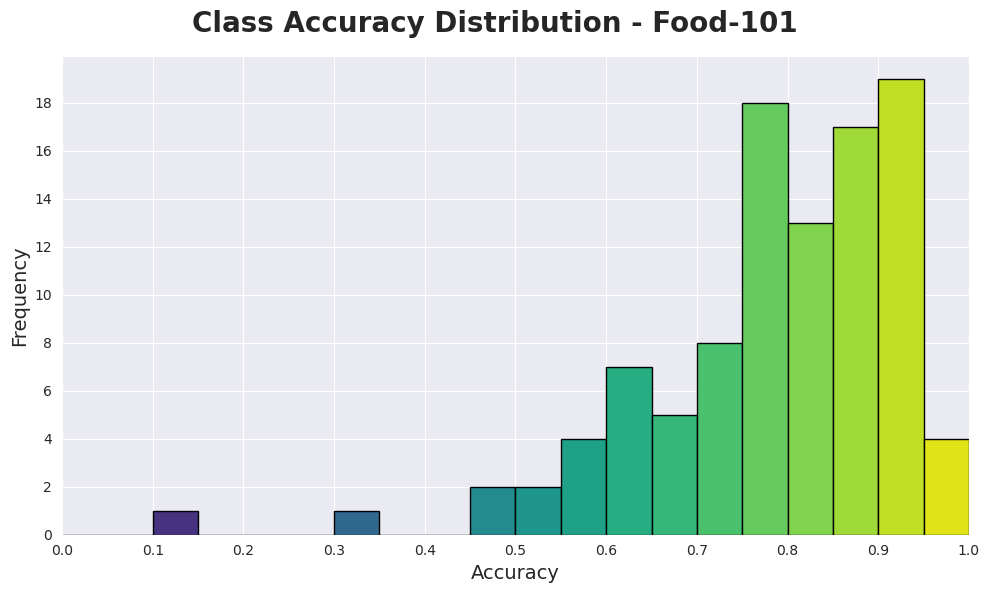

In [224]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [225]:
clip_fer2013_16 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [226]:
get_model_params(clip_fer2013_16)

Parameters: 85.80M


In [227]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013_16,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 14/14 [00:01<00:00, 11.15it/s]


Epochs: 1/10 | train_loss: 1.9805 | train_acc: 0.1964


100%|██████████| 14/14 [00:01<00:00, 11.09it/s]


Epochs: 2/10 | train_loss: 1.8021 | train_acc: 0.3571


100%|██████████| 14/14 [00:01<00:00, 10.59it/s]


Epochs: 3/10 | train_loss: 1.6703 | train_acc: 0.5446


100%|██████████| 14/14 [00:01<00:00, 11.09it/s]


Epochs: 4/10 | train_loss: 1.5692 | train_acc: 0.6339


100%|██████████| 14/14 [00:01<00:00, 11.07it/s]


Epochs: 5/10 | train_loss: 1.4780 | train_acc: 0.6875


100%|██████████| 14/14 [00:01<00:00, 11.12it/s]


Epochs: 6/10 | train_loss: 1.3748 | train_acc: 0.7321


100%|██████████| 14/14 [00:01<00:00, 10.72it/s]


Epochs: 7/10 | train_loss: 1.3097 | train_acc: 0.7411


100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


Epochs: 8/10 | train_loss: 1.2208 | train_acc: 0.7946


100%|██████████| 14/14 [00:01<00:00, 11.14it/s]


Epochs: 9/10 | train_loss: 1.1710 | train_acc: 0.8036


100%|██████████| 14/14 [00:01<00:00, 11.11it/s]

Epochs: 10/10 | train_loss: 1.1235 | train_acc: 0.7946


In [228]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013_16,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:40<00:00, 11.21it/s]

test_loss: 1.6062 | test_acc: 0.4051


In [229]:
fer2013_accs.append(fer2013_acc)

In [230]:
fer2013_per_class_acc

{'angry': 0.3727087576374745,
 'disgust': 0.5272727272727272,
 'fear': 0.22727272727272727,
 'happy': 0.6052332195676906,
 'sad': 0.21885521885521886,
 'surprise': 0.3894230769230769,
 'neutral': 0.476038338658147}

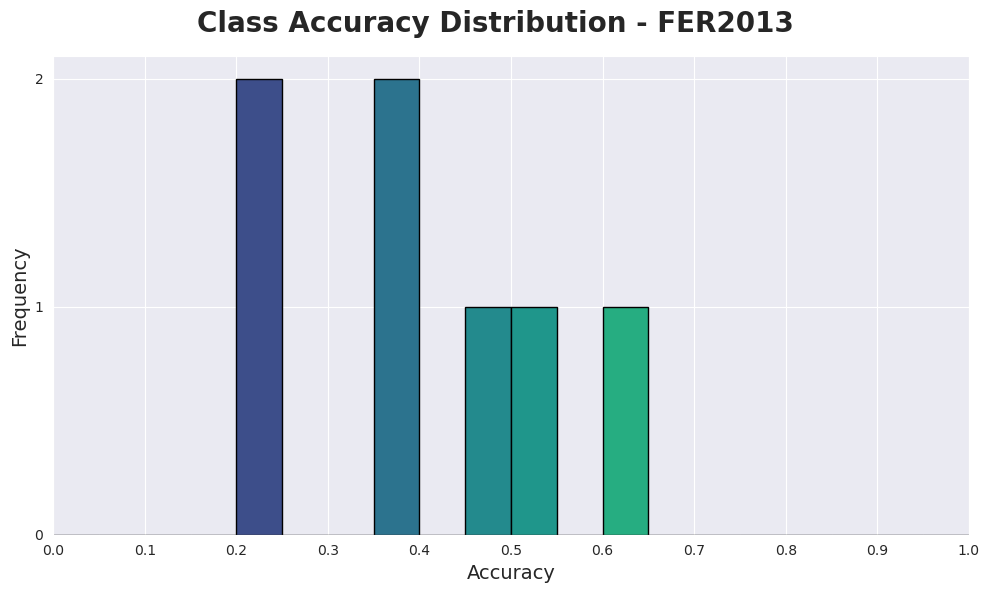

In [231]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [232]:
clip_pcam_16 = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [233]:
get_model_params(clip_pcam_16)

Parameters: 85.80M


In [234]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam_16,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


Epochs: 1/10 | train_loss: 0.7491 | train_acc: 0.4375


100%|██████████| 4/4 [00:00<00:00, 10.97it/s]


Epochs: 2/10 | train_loss: 0.7107 | train_acc: 0.4062


100%|██████████| 4/4 [00:00<00:00, 10.75it/s]


Epochs: 3/10 | train_loss: 0.6765 | train_acc: 0.5312


100%|██████████| 4/4 [00:00<00:00, 10.99it/s]


Epochs: 4/10 | train_loss: 0.6471 | train_acc: 0.6562


100%|██████████| 4/4 [00:00<00:00, 10.94it/s]


Epochs: 5/10 | train_loss: 0.6172 | train_acc: 0.7188


100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Epochs: 6/10 | train_loss: 0.5960 | train_acc: 0.6875


100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


Epochs: 7/10 | train_loss: 0.5781 | train_acc: 0.6562


100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Epochs: 8/10 | train_loss: 0.5563 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Epochs: 9/10 | train_loss: 0.5382 | train_acc: 0.9062


100%|██████████| 4/4 [00:00<00:00, 10.82it/s]

Epochs: 10/10 | train_loss: 0.5282 | train_acc: 0.9062


In [235]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam_16,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:11<00:00, 11.04it/s]

test_loss: 0.6041 | test_acc: 0.6960


In [236]:
pcam_accs.append(pcam_acc)

In [237]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.8238667561466658,
 'lymph node tumor tissue': 0.5681138181596141}

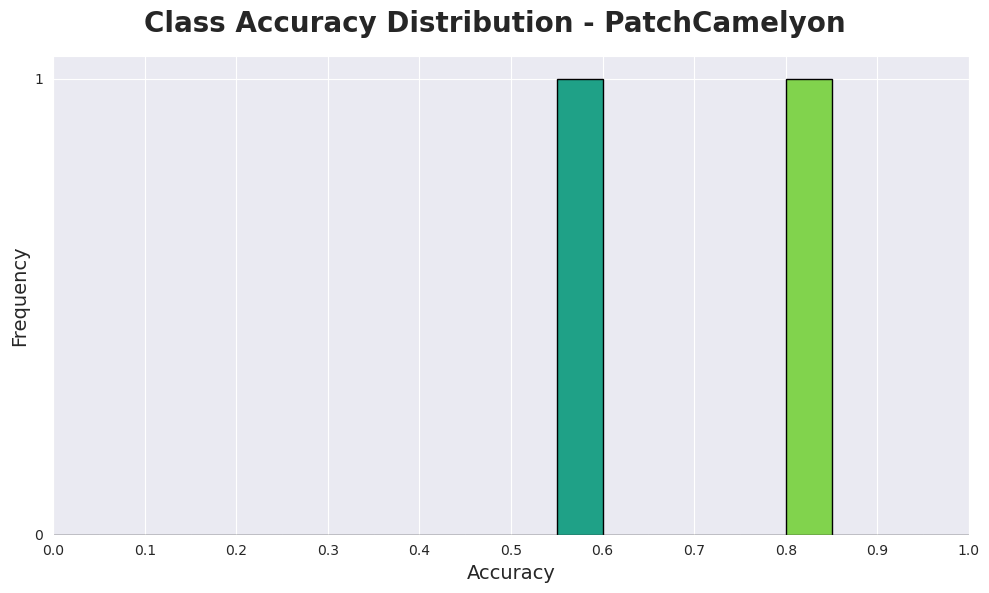

In [238]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [239]:
clip_sun397_16 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [240]:
get_model_params(clip_sun397_16)

Parameters: 86.10M


In [241]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397_16,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 794/794 [01:34<00:00,  8.37it/s]


Epochs: 1/10 | train_loss: 4.5002 | train_acc: 0.2442


100%|██████████| 794/794 [01:33<00:00,  8.48it/s]


Epochs: 2/10 | train_loss: 2.0405 | train_acc: 0.6107


100%|██████████| 794/794 [01:33<00:00,  8.51it/s]


Epochs: 3/10 | train_loss: 1.2778 | train_acc: 0.7418


100%|██████████| 794/794 [01:33<00:00,  8.45it/s]


Epochs: 4/10 | train_loss: 0.9314 | train_acc: 0.8062


100%|██████████| 794/794 [01:33<00:00,  8.49it/s]


Epochs: 5/10 | train_loss: 0.7192 | train_acc: 0.8459


100%|██████████| 794/794 [01:33<00:00,  8.51it/s]


Epochs: 6/10 | train_loss: 0.5714 | train_acc: 0.8785


100%|██████████| 794/794 [01:33<00:00,  8.50it/s]


Epochs: 7/10 | train_loss: 0.4615 | train_acc: 0.9032


100%|██████████| 794/794 [01:33<00:00,  8.49it/s]


Epochs: 8/10 | train_loss: 0.3710 | train_acc: 0.9314


100%|██████████| 794/794 [01:33<00:00,  8.49it/s]


Epochs: 9/10 | train_loss: 0.3006 | train_acc: 0.9474


100%|██████████| 794/794 [01:33<00:00,  8.48it/s]


Epochs: 10/10 | train_loss: 0.2466 | train_acc: 0.9613


In [242]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397_16,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:20<00:00,  8.48it/s]


test_loss: 1.2647 | test_acc: 0.6557


In [243]:
sun397_accs.append(sun397_acc)

In [244]:
get_top_5_accuracies(sun397_per_class_acc)

[('electrical substation', 1.0),
 ('parking garage (indoor)', 1.0),
 ('raceway', 1.0),
 ('underwater (coral reef)', 0.9913793103448276),
 ('subway interior', 0.9880952380952381)]

In [245]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('beach', 0.04782608695652174),
 ('assembly line', 0.09090909090909091),
 ('library (outdoor)', 0.09523809523809523),
 ('waterfall (plunge)', 0.1111111111111111),
 ('game room', 0.1276595744680851)]

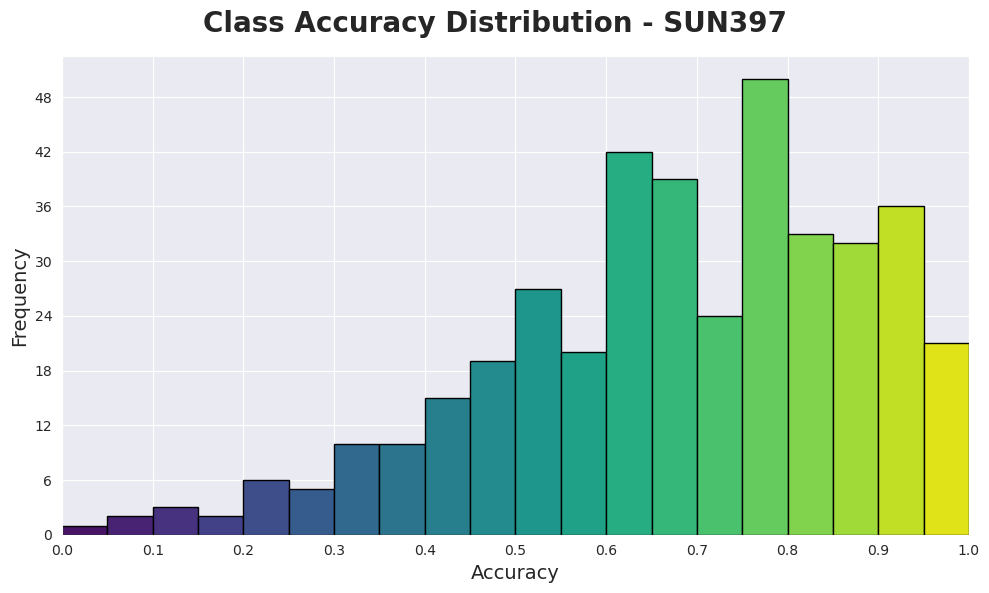

In [246]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [247]:
clip_dtd_16 = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [248]:
get_model_params(clip_dtd_16)

Parameters: 85.84M


In [249]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd_16,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


Epochs: 1/10 | train_loss: 3.4525 | train_acc: 0.2487


100%|██████████| 94/94 [00:11<00:00,  7.96it/s]


Epochs: 2/10 | train_loss: 2.3505 | train_acc: 0.6144


100%|██████████| 94/94 [00:11<00:00,  8.13it/s]


Epochs: 3/10 | train_loss: 1.7240 | train_acc: 0.6995


100%|██████████| 94/94 [00:11<00:00,  8.13it/s]


Epochs: 4/10 | train_loss: 1.3486 | train_acc: 0.7766


100%|██████████| 94/94 [00:11<00:00,  8.13it/s]


Epochs: 5/10 | train_loss: 1.0970 | train_acc: 0.8112


100%|██████████| 94/94 [00:11<00:00,  8.15it/s]


Epochs: 6/10 | train_loss: 0.9207 | train_acc: 0.8364


100%|██████████| 94/94 [00:11<00:00,  8.14it/s]


Epochs: 7/10 | train_loss: 0.7905 | train_acc: 0.8790


100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


Epochs: 8/10 | train_loss: 0.6926 | train_acc: 0.9096


100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


Epochs: 9/10 | train_loss: 0.6063 | train_acc: 0.9202


100%|██████████| 94/94 [00:11<00:00,  8.10it/s]

Epochs: 10/10 | train_loss: 0.5393 | train_acc: 0.9428


In [250]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd_16,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.66it/s]

test_loss: 1.2703 | test_acc: 0.6670


In [251]:
dtd_accs.append(dtd_acc)

In [252]:
get_top_5_accuracies(dtd_per_class_acc)

[('zigzagged', 1.0),
 ('paisley', 0.975),
 ('cobwebbed', 0.95),
 ('crystalline', 0.95),
 ('swirly', 0.95)]

In [253]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('woven', 0.2),
 ('marbled', 0.25),
 ('blotchy', 0.275),
 ('pitted', 0.275),
 ('bumpy', 0.3)]

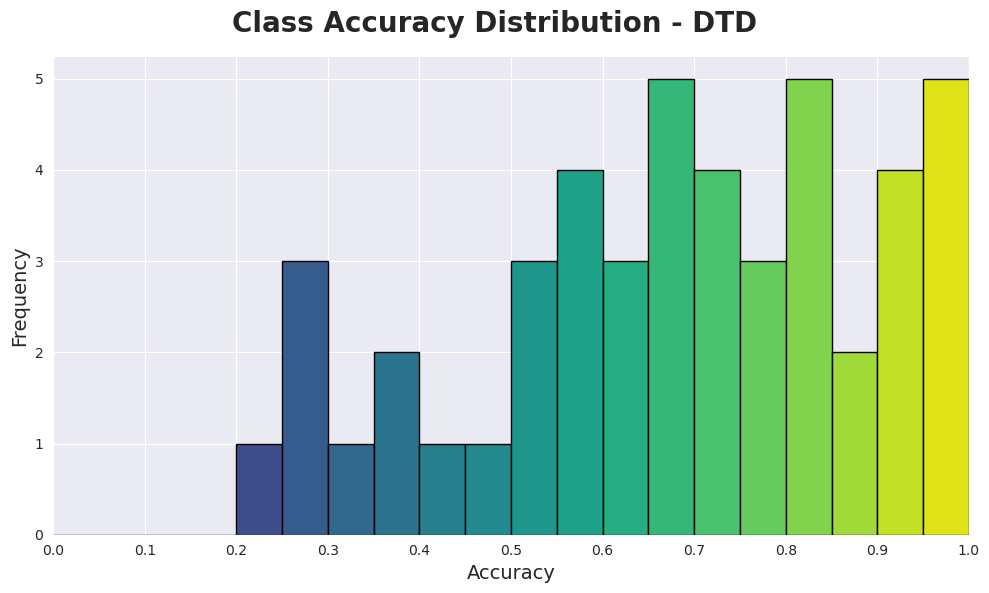

In [254]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [5]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [6]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']
n_shots = [1, 2, 4, 8, 16]

In [7]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [8]:
df = pd.DataFrame(results, columns=[f"{n}-shot linear probe" for n in n_shots], index=labels)
df

,1-shot linear probe,2-shot linear probe,4-shot linear probe,8-shot linear probe,16-shot linear probe
RESISC45,0.476032,0.585079,0.731587,0.786508,0.821429
Food-101,0.358733,0.535208,0.646535,0.727960,0.785267
FER2013,0.226247,0.200613,0.262190,0.321538,0.405127
PatchCamelyon,0.514862,0.553131,0.638550,0.656250,0.696045
SUN397,0.350621,0.479172,0.555402,0.616552,0.655724
DTD,0.379787,0.475532,0.569681,0.626596,0.667021
